Group 1 has 105 exercises across 5 sessions
Group 2 has 105 exercises across 5 sessions
Group 3 has 105 exercises across 5 sessions
Group 4 has 105 exercises across 5 sessions


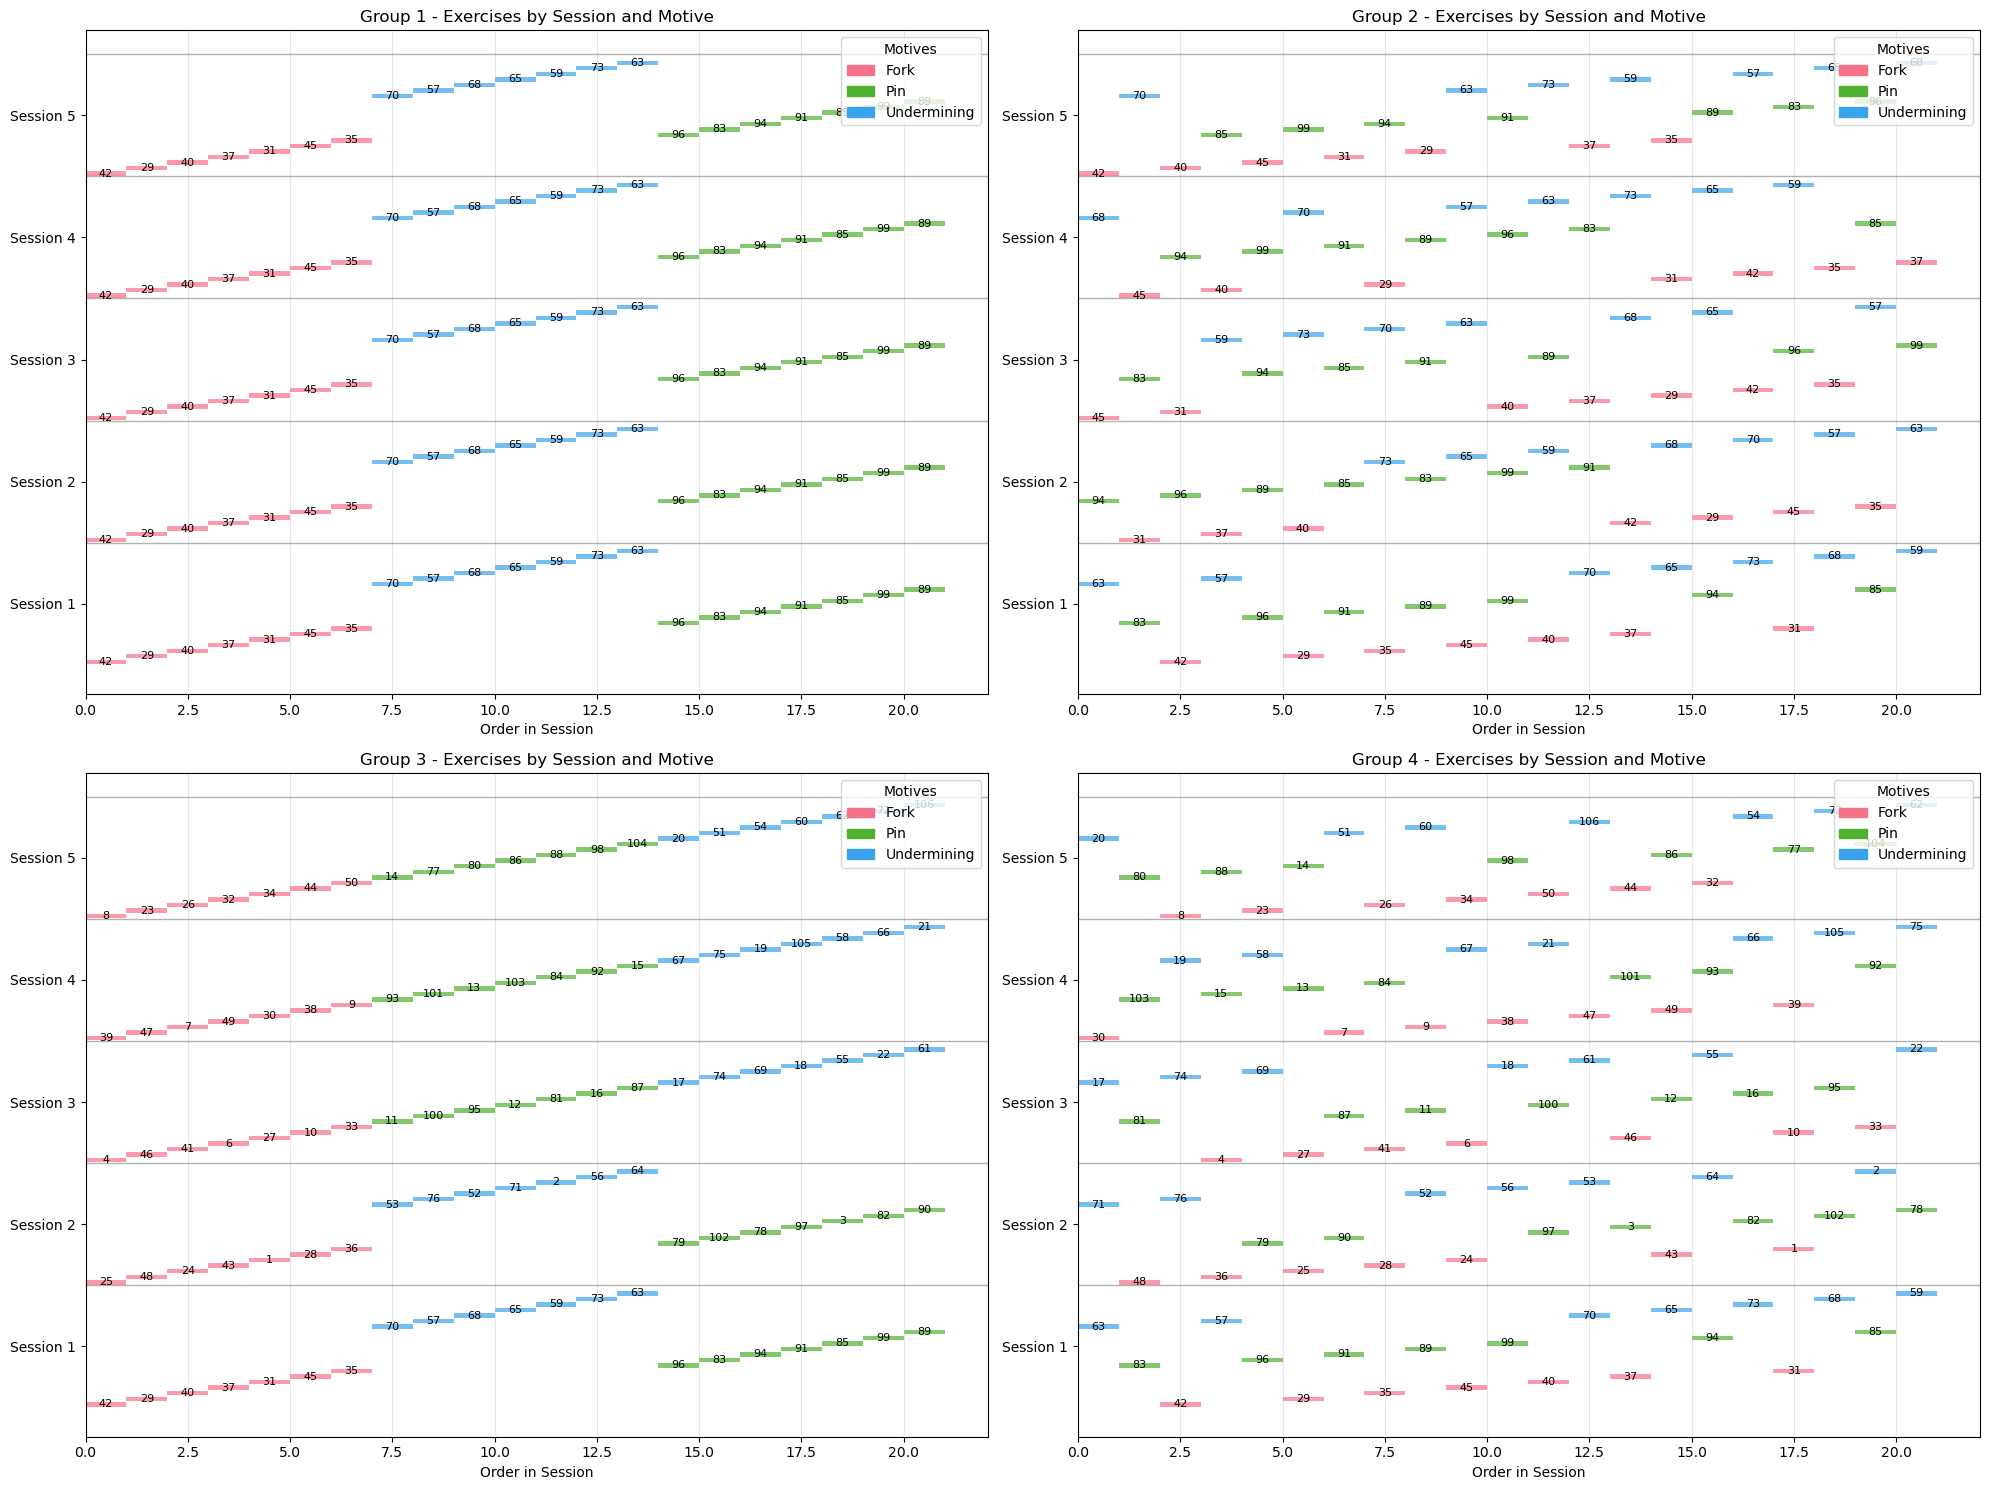

/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_89463/289883262.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1) if pd.notna(x) else -1)
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_89463/289883262.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1) if pd.notna(x) else -1)
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_89463/289883262.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1) if pd.notna(x) else -1)
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_89463/289883262.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: m

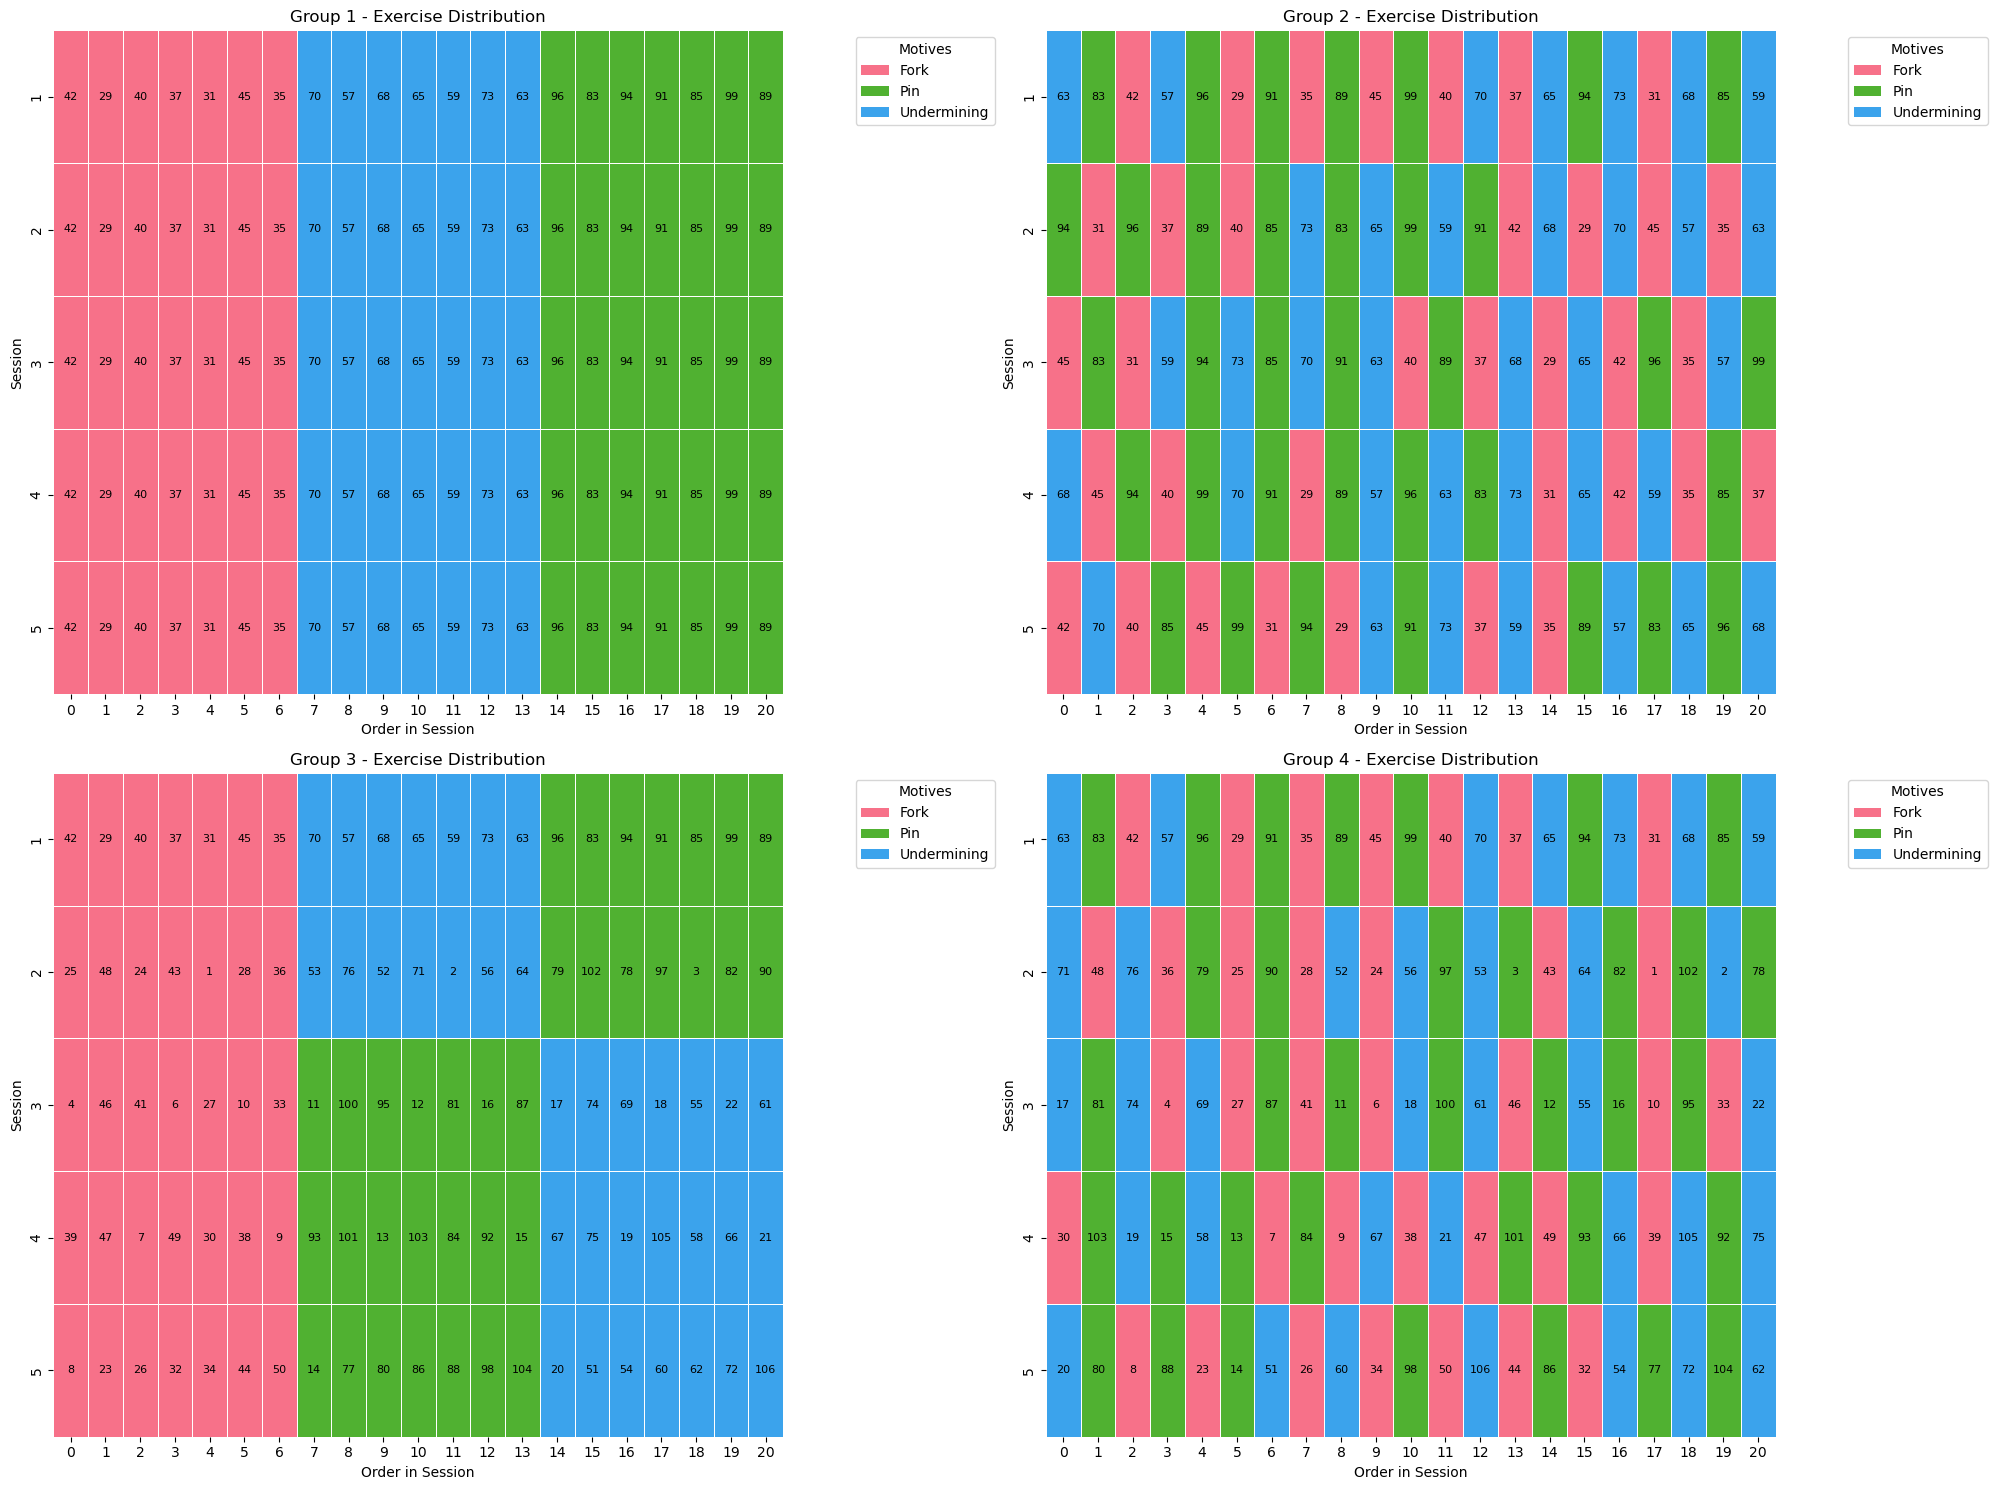

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import json

# Function to parse the string representation of dictionaries
def parse_dict_string(s):
    try:
        # Replace single quotes with double quotes for proper JSON parsing
        s = s.replace("'", '"')
        return json.loads(s)
    except:
        return None

# 1. Read each group from CSV
groups_data = {}
for i in range(1, 5):
    file_name = f'group{i}.csv'

    # Read the raw CSV
    raw_df = pd.read_csv(file_name)

    # Process each column which contains exercise data
    exercises = []
    for col in raw_df.columns:
        for cell in raw_df[col]:
            if isinstance(cell, str):
                exercise_dict = parse_dict_string(cell)
                if exercise_dict:
                    exercises.append(exercise_dict)

    # Create a proper DataFrame from the parsed exercises
    groups_data[i] = pd.DataFrame(exercises)

    # Print basic info about each group
    print(f"Group {i} has {len(groups_data[i])} exercises across {groups_data[i]['session'].nunique()} sessions")

# Create a color palette for motives
all_motives = set()
for group_df in groups_data.values():
    all_motives.update(group_df['motives'].unique())

# Create a color map for motives
colors = sns.color_palette("husl", len(all_motives))
motive_color_map = dict(zip(sorted(all_motives), colors))

# 2. Create visualizations for each group
plt.figure(figsize=(20, 15))

for group_num, group_df in groups_data.items():
    plt.subplot(2, 2, group_num)

    # Sort by session and order_in_session
    group_df = group_df.sort_values(['session', 'order_in_session'])

    # Get unique sessions
    sessions = sorted(group_df['session'].unique())

    # Set up the plot
    y_positions = {}
    y_ticks = []
    y_labels = []

    current_y = 0

    # For each session
    for session in sessions:
        session_data = group_df[group_df['session'] == session]
        session_start_y = current_y

        # Group exercises by motive within the session
        for motive in sorted(session_data['motives'].unique()):
            motive_data = session_data[session_data['motives'] == motive]

            # Plot each exercise in this motive group
            for _, exercise in motive_data.iterrows():
                plt.barh(current_y, 1, left=exercise['order_in_session'],
                         color=motive_color_map[motive], alpha=0.7)
                plt.text(exercise['order_in_session'] + 0.5, current_y,
                         f"{exercise['id']}", va='center', ha='center', fontsize=8)
                current_y += 1

        # Add session label
        y_ticks.append(session_start_y + (current_y - session_start_y) / 2)
        y_labels.append(f"Session {session}")

        # Add space between sessions
        current_y += 1
        plt.axhline(y=current_y-0.5, color='black', linestyle='-', alpha=0.3, linewidth=1)

    plt.yticks(y_ticks, y_labels)
    plt.title(f"Group {group_num} - Exercises by Session and Motive")
    plt.xlabel("Order in Session")
    plt.grid(axis='x', alpha=0.3)

    # Create a legend for motives
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=motive_color_map[motive])
                      for motive in sorted(motive_color_map.keys())]
    plt.legend(legend_elements, sorted(motive_color_map.keys()),
              title="Motives", loc='upper right')

plt.tight_layout()
plt.savefig('group_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Alternative visualization: Heatmap showing exercise distribution
plt.figure(figsize=(20, 15))

for group_num, group_df in groups_data.items():
    plt.subplot(2, 2, group_num)

    # Create a pivot table: sessions as rows, order_in_session as columns, motives as values
    pivot_data = group_df.pivot_table(
        index='session',
        columns='order_in_session',
        values='motives',
        aggfunc='first'
    )

    # Create a numeric representation for motives
    motive_to_num = {motive: i for i, motive in enumerate(sorted(all_motives))}

    # Convert motives to numbers for the heatmap
    numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1) if pd.notna(x) else -1)

    # Create the heatmap
    sns.heatmap(numeric_pivot, cmap=sns.color_palette("husl", len(all_motives)),
                cbar=False, linewidths=0.5, linecolor='white')

    # Add exercise IDs as text in each cell
    for session in pivot_data.index:
        for order in pivot_data.columns:
            if pd.notna(pivot_data.loc[session, order]):
                exercise = group_df[(group_df['session'] == session) &
                                   (group_df['order_in_session'] == order)]
                if not exercise.empty:
                    plt.text(order + 0.5, session - 0.5,
                             f"{exercise['id'].values[0]}",
                             ha='center', va='center', fontsize=8)

    plt.title(f"Group {group_num} - Exercise Distribution")
    plt.xlabel("Order in Session")
    plt.ylabel("Session")

    # Create a custom colorbar legend for motives
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], label=motive)
                      for i, motive in enumerate(sorted(all_motives))]
    plt.legend(handles=legend_elements, title="Motives",
              loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.savefig('group_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
exercises = pd.read_csv('exercises.csv')

In [7]:
import pandas as pd
import json
import ast
import re

# Function to parse dictionary-like strings from CSV files
def parse_dict_string(s):
    if not isinstance(s, str):
        return None
    try:
        # Replace single quotes with double quotes for proper JSON parsing
        s = s.replace("'", '"')
        return json.loads(s)
    except:
        try:
            # Try using ast.literal_eval as a fallback
            return ast.literal_eval(s)
        except:
            return None

# 1. Load exercises from CSV file
exercises_df = pd.read_csv('exercises.csv')
print(f"Loaded {len(exercises_df)} exercises from CSV file")

# 2. Parse group data from CSV files
groups_data = {}
all_exercises = []

for i in range(1, 5):
    try:
        file_name = f'group{i}.csv'

        # Read the raw CSV
        raw_df = pd.read_csv(file_name)

        # Process each column which contains exercise data
        exercises = []
        for col in raw_df.columns:
            for cell in raw_df[col]:
                if isinstance(cell, str):
                    exercise_dict = parse_dict_string(cell)
                    if exercise_dict:
                        # Add group information
                        exercise_dict['group'] = i
                        exercises.append(exercise_dict)

        groups_data[i] = pd.DataFrame(exercises)
        all_exercises.extend(exercises)
        print(f"Loaded {len(exercises)} exercises from Group {i}")
    except Exception as e:
        print(f"Error loading Group {i}: {e}")

# 3. Create a DataFrame from all group exercises
group_exercises_df = pd.DataFrame(all_exercises)

Loaded 105 exercises from CSV file
Loaded 105 exercises from Group 1
Loaded 105 exercises from Group 2
Loaded 105 exercises from Group 3
Loaded 105 exercises from Group 4


In [8]:
group_exercises_df

,id,motives,session,order_in_session,group
0,42,Fork,1,0,1
1,42,Fork,2,0,1
2,42,Fork,3,0,1
3,42,Fork,4,0,1
4,42,Fork,5,0,1
...,...,...,...,...,...
415,59,Undermining,1,20,4
416,78,Pin,2,20,4
417,22,Undermining,3,20,4
418,75,Undermining,4,20,4


In [ ]:
def parse_moves(moves_str):
    if isinstance(moves_str, str):
        try:
            # Try to parse as JSON
            return json.loads(moves_str)
        except:
            # Try to extract moves using regex
            pattern = r'"([a-h][1-8][a-h][1-8])"'
            matches = re.findall(pattern, moves_str)
            if matches:
                return matches
    return moves_str

exercises_df['moves'] = exercises_df['moves'].apply(parse_moves)

In [10]:
import pandas as pd
import json
import ast
import re
import sqlite3
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Text, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker

# Function to parse dictionary-like strings from CSV files
def parse_dict_string(s):
    if not isinstance(s, str):
        return None
    try:
        # Replace single quotes with double quotes for proper JSON parsing
        s = s.replace("'", '"')
        return json.loads(s)
    except:
        try:
            # Try using ast.literal_eval as a fallback
            return ast.literal_eval(s)
        except:
            return None

# 1. Load exercises from CSV file
exercises_df = pd.read_csv('exercises.csv')
print(f"Loaded {len(exercises_df)} exercises from CSV file")

# 2. Parse group data from CSV files
groups_data = {}
all_group_exercises = []

for i in range(1, 5):
    try:
        file_name = f'group{i}.csv'

        # Read the raw CSV
        raw_df = pd.read_csv(file_name)

        # Process each column which contains exercise data
        group_exercises = []
        for col in raw_df.columns:
            for cell in raw_df[col]:
                if isinstance(cell, str):
                    exercise_dict = parse_dict_string(cell)
                    if exercise_dict:
                        # Add group information
                        exercise_dict['group'] = i
                        group_exercises.append(exercise_dict)

        groups_data[i] = pd.DataFrame(group_exercises)
        all_group_exercises.extend(group_exercises)
        print(f"Loaded {len(group_exercises)} exercises from Group {i}")
    except Exception as e:
        print(f"Error loading Group {i}: {e}")

# 3. Create a DataFrame from all group exercises
group_exercises_df = pd.DataFrame(all_group_exercises)
print(f"Combined {len(group_exercises_df)} exercises from all groups")

# 4. Merge the group_exercises_df with the main exercises_df
# First, create a mapping of exercise IDs to their details from exercises_df
exercise_details = {}
for _, row in exercises_df.iterrows():
    exercise_details[row['id']] = row.to_dict()

# Add exercise details to the group_exercises_df
for i, row in group_exercises_df.iterrows():
    exercise_id = row['id']
    if exercise_id in exercise_details:
        details = exercise_details[exercise_id]
        for key, value in details.items():
            if key not in group_exercises_df.columns:
                group_exercises_df.loc[i, key] = value

# 5. Create a relational database structure
Base = declarative_base()

class Exercise(Base):
    __tablename__ = 'exercises'

    id = Column(Integer, primary_key=True)
    initial_fen = Column(String(100))
    moves = Column(Text)
    starting_color = Column(String(10))
    motives = Column(String(50))
    created_at = Column(String(50))

    # Relationship with ExerciseSession
    sessions = relationship("ExerciseSession", back_populates="exercise")

    def __repr__(self):
        return f"<Exercise(id={self.id}, motives={self.motives})>"

class Group(Base):
    __tablename__ = 'groups'

    id = Column(Integer, primary_key=True)
    name = Column(String(50))

    # Relationship with Session
    sessions = relationship("Session", back_populates="group")

    def __repr__(self):
        return f"<Group(id={self.id}, name={self.name})>"

class Session(Base):
    __tablename__ = 'sessions'

    id = Column(Integer, primary_key=True)
    session_number = Column(Integer)
    group_id = Column(Integer, ForeignKey('groups.id'))

    # Relationships
    group = relationship("Group", back_populates="sessions")
    exercise_sessions = relationship("ExerciseSession", back_populates="session")

    def __repr__(self):
        return f"<Session(id={self.id}, group_id={self.group_id}, session_number={self.session_number})>"

class ExerciseSession(Base):
    __tablename__ = 'exercise_sessions'

    id = Column(Integer, primary_key=True)
    exercise_id = Column(Integer, ForeignKey('exercises.id'))
    session_id = Column(Integer, ForeignKey('sessions.id'))
    order_in_session = Column(Integer)

    # Relationships
    exercise = relationship("Exercise", back_populates="sessions")
    session = relationship("Session", back_populates="exercise_sessions")

    def __repr__(self):
        return f"<ExerciseSession(exercise_id={self.exercise_id}, session_id={self.session_id}, order={self.order_in_session})>"

# Create the database
engine = create_engine('sqlite:///chess_exercises.db')
Base.metadata.create_all(engine)

# Create a session to interact with the database
Session_db = sessionmaker(bind=engine)
session_db = Session_db()

# 6. Populate the database with data
# First, add all exercises
for _, row in exercises_df.iterrows():
    exercise = Exercise(
        id=row['id'],
        initial_fen=row['initial_fen'],
        moves=str(row['moves']),  # Convert to string for storage
        starting_color=row['starting_color'],
        motives=row['motives'],
        created_at=row['created_at']
    )
    session_db.add(exercise)

# Add groups
for group_id in range(1, 5):
    group = Group(
        id=group_id,
        name=f"Group {group_id}"
    )
    session_db.add(group)

# Add sessions and exercise_sessions
session_mapping = {}  # To keep track of session objects

for _, row in group_exercises_df.iterrows():
    group_id = row['group']
    session_number = row['session']

    # Create a unique key for this session
    session_key = (group_id, session_number)

    # Check if we've already created this session
    if session_key not in session_mapping:
        # Create a new session
        session = Session(
            group_id=group_id,
            session_number=session_number
        )
        session_db.add(session)
        session_db.flush()  # To get the session ID
        session_mapping[session_key] = session
    else:
        session = session_mapping[session_key]

    # Create the exercise_session relationship
    exercise_session = ExerciseSession(
        exercise_id=row['id'],
        session_id=session.id,
        order_in_session=row['order_in_session']
    )
    session_db.add(exercise_session)

# Commit all changes
session_db.commit()

print("\nDatabase created successfully with the following structure:")
print("- exercises: Contains all exercise details")
print("- groups: Contains the 4 groups")
print("- sessions: Contains sessions for each group")
print("- exercise_sessions: Maps exercises to sessions with order information")

# 7. Verify the database contents
exercise_count = session_db.query(Exercise).count()
group_count = session_db.query(Group).count()
session_count = session_db.query(Session).count()
exercise_session_count = session_db.query(ExerciseSession).count()

print(f"\nDatabase contains:")
print(f"- {exercise_count} exercises")
print(f"- {group_count} groups")
print(f"- {session_count} sessions")
print(f"- {exercise_session_count} exercise-session mappings")

# Close the database session
session_db.close()

# 8. Example query to demonstrate the relational structure
print("\nExample query: Get all exercises for Group 1, Session 1")
session_db = Session_db()
group1_session1 = session_db.query(Session).filter_by(group_id=1, session_number=1).first()
if group1_session1:
    exercises = session_db.query(Exercise).join(ExerciseSession).filter(
        ExerciseSession.session_id == group1_session1.id
    ).order_by(ExerciseSession.order_in_session).all()

    print(f"Found {len(exercises)} exercises in Group 1, Session 1:")
    for i, exercise in enumerate(exercises[:5]):  # Show first 5 for brevity
        print(f"  {i+1}. Exercise ID: {exercise.id}, Motive: {exercise.motives}")
    if len(exercises) > 5:
        print(f"  ... and {len(exercises) - 5} more")
else:
    print("Group 1, Session 1 not found")

session_db.close()

Loaded 105 exercises from CSV file
Loaded 105 exercises from Group 1
Loaded 105 exercises from Group 2
Loaded 105 exercises from Group 3
Loaded 105 exercises from Group 4
Combined 420 exercises from all groups

Database created successfully with the following structure:
- exercises: Contains all exercise details
- groups: Contains the 4 groups
- sessions: Contains sessions for each group
- exercise_sessions: Maps exercises to sessions with order information

Database contains:
- 105 exercises
- 4 groups
- 20 sessions
- 420 exercise-session mappings

Example query: Get all exercises for Group 1, Session 1
Found 21 exercises in Group 1, Session 1:
  1. Exercise ID: 42, Motive: Fork
  2. Exercise ID: 29, Motive: Fork
  3. Exercise ID: 40, Motive: Fork
  4. Exercise ID: 37, Motive: Fork
  5. Exercise ID: 31, Motive: Fork
  ... and 16 more


/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_89463/3202172000.py:77: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [11]:
import sqlite3
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

# Connect to the database
engine = create_engine('sqlite:///chess_exercises.db')
Session = sessionmaker(bind=engine)
session = Session()

try:
    # Start a transaction
    session.begin()

    print("Starting ID correction process...")

    # 1. First, let's check the current ID distribution
    result = session.execute(text("SELECT id FROM exercises ORDER BY id")).fetchall()
    original_ids = [row[0] for row in result]
    print(f"Original IDs: {original_ids[:10]}... (showing first 10)")
    print(f"Total exercises before correction: {len(original_ids)}")

    # 2. Create a temporary table to avoid unique constraint violations during the update
    session.execute(text("CREATE TABLE temp_exercises AS SELECT * FROM exercises"))

    # 3. Update the exercise_sessions table first (foreign key references)
    session.execute(text("""
        UPDATE exercise_sessions
        SET exercise_id = exercise_id - 1
        WHERE exercise_id >= 6
    """))

    # 4. Delete all records from the original exercises table
    session.execute(text("DELETE FROM exercises"))

    # 5. Insert back from temp with corrected IDs
    session.execute(text("""
        INSERT INTO exercises
        SELECT
            CASE WHEN id >= 6 THEN id - 1 ELSE id END as id,
            initial_fen,
            moves,
            starting_color,
            motives,
            created_at
        FROM temp_exercises
    """))

    # 6. Drop the temporary table
    session.execute(text("DROP TABLE temp_exercises"))

    # 7. Verify the correction
    result = session.execute(text("SELECT id FROM exercises ORDER BY id")).fetchall()
    new_ids = [row[0] for row in result]
    print(f"New IDs: {new_ids[:10]}... (showing first 10)")
    print(f"Total exercises after correction: {len(new_ids)}")

    # Check if there are any gaps in the sequence
    min_id = min(new_ids)
    max_id = max(new_ids)
    expected_count = max_id - min_id + 1

    if len(new_ids) == expected_count:
        print(f"Success! ID sequence is now continuous from {min_id} to {max_id}")
    else:
        print(f"Warning: There may still be gaps in the ID sequence")
        # Find the gaps
        expected_ids = set(range(min_id, max_id + 1))
        actual_ids = set(new_ids)
        missing_ids = expected_ids - actual_ids
        if missing_ids:
            print(f"Missing IDs: {sorted(missing_ids)}")

    # Commit the transaction
    session.commit()
    print("ID correction completed successfully")

except Exception as e:
    # Rollback in case of error
    session.rollback()
    print(f"Error during ID correction: {e}")

finally:
    # Close the session
    session.close()

# Additional verification query to check the relationships
try:
    session = Session()

    # Check if all exercise_sessions reference valid exercises
    invalid_refs = session.execute(text("""
        SELECT es.id, es.exercise_id
        FROM exercise_sessions es
        LEFT JOIN exercises e ON es.exercise_id = e.id
        WHERE e.id IS NULL
    """)).fetchall()

    if invalid_refs:
        print(f"Warning: Found {len(invalid_refs)} invalid exercise references in exercise_sessions")
        print(f"First few invalid references: {invalid_refs[:5]}")
    else:
        print("All exercise references in exercise_sessions are valid")

    # Check the distribution of exercises across groups and sessions
    distribution = session.execute(text("""
        SELECT g.id as group_id, s.session_number, COUNT(es.exercise_id) as exercise_count
        FROM groups g
        JOIN sessions s ON g.id = s.group_id
        JOIN exercise_sessions es ON s.id = es.session_id
        GROUP BY g.id, s.session_number
        ORDER BY g.id, s.session_number
    """)).fetchall()

    print("\nExercise distribution across groups and sessions:")
    for group_id, session_number, count in distribution:
        print(f"Group {group_id}, Session {session_number}: {count} exercises")

finally:
    session.close()

Starting ID correction process...
Original IDs: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11]... (showing first 10)
Total exercises before correction: 105
New IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]... (showing first 10)
Total exercises after correction: 105
Success! ID sequence is now continuous from 1 to 105
ID correction completed successfully
All exercise references in exercise_sessions are valid

Exercise distribution across groups and sessions:
Group 1, Session 1: 21 exercises
Group 1, Session 2: 21 exercises
Group 1, Session 3: 21 exercises
Group 1, Session 4: 21 exercises
Group 1, Session 5: 21 exercises
Group 2, Session 1: 21 exercises
Group 2, Session 2: 21 exercises
Group 2, Session 3: 21 exercises
Group 2, Session 4: 21 exercises
Group 2, Session 5: 21 exercises
Group 3, Session 1: 21 exercises
Group 3, Session 2: 21 exercises
Group 3, Session 3: 21 exercises
Group 3, Session 4: 21 exercises
Group 3, Session 5: 21 exercises
Group 4, Session 1: 21 exercises
Group 4, Session 2: 21 exercises


Starting to fix exercise order in Group 3, Sessions 3, 4, and 5...
Found session IDs: {3: 13, 4: 14, 5: 15}

Processing Session 3 (ID: 13)...
Session 3 has:
  7 Fork exercises
  7 Undermining exercises
  7 Pin exercises
Updating 21 exercises for Session 3...
Updated -1 rows for Session 3

Processing Session 4 (ID: 14)...
Session 4 has:
  7 Fork exercises
  7 Undermining exercises
  7 Pin exercises
Updating 21 exercises for Session 4...
Updated -1 rows for Session 4

Processing Session 5 (ID: 15)...
Session 5 has:
  7 Fork exercises
  7 Undermining exercises
  7 Pin exercises
Updating 21 exercises for Session 5...
Updated -1 rows for Session 5
Changes committed to database.

Verifying changes...

Session 3 new order:
  Order 0: Exercise 4 - Fork
  Order 1: Exercise 45 - Fork
  Order 2: Exercise 40 - Fork
  Order 3: Exercise 5 - Fork
  Order 4: Exercise 26 - Fork
  Order 5: Exercise 9 - Fork
  Order 6: Exercise 32 - Fork
  Order 7: Exercise 16 - Undermining
  Order 8: Exercise 73 - Under

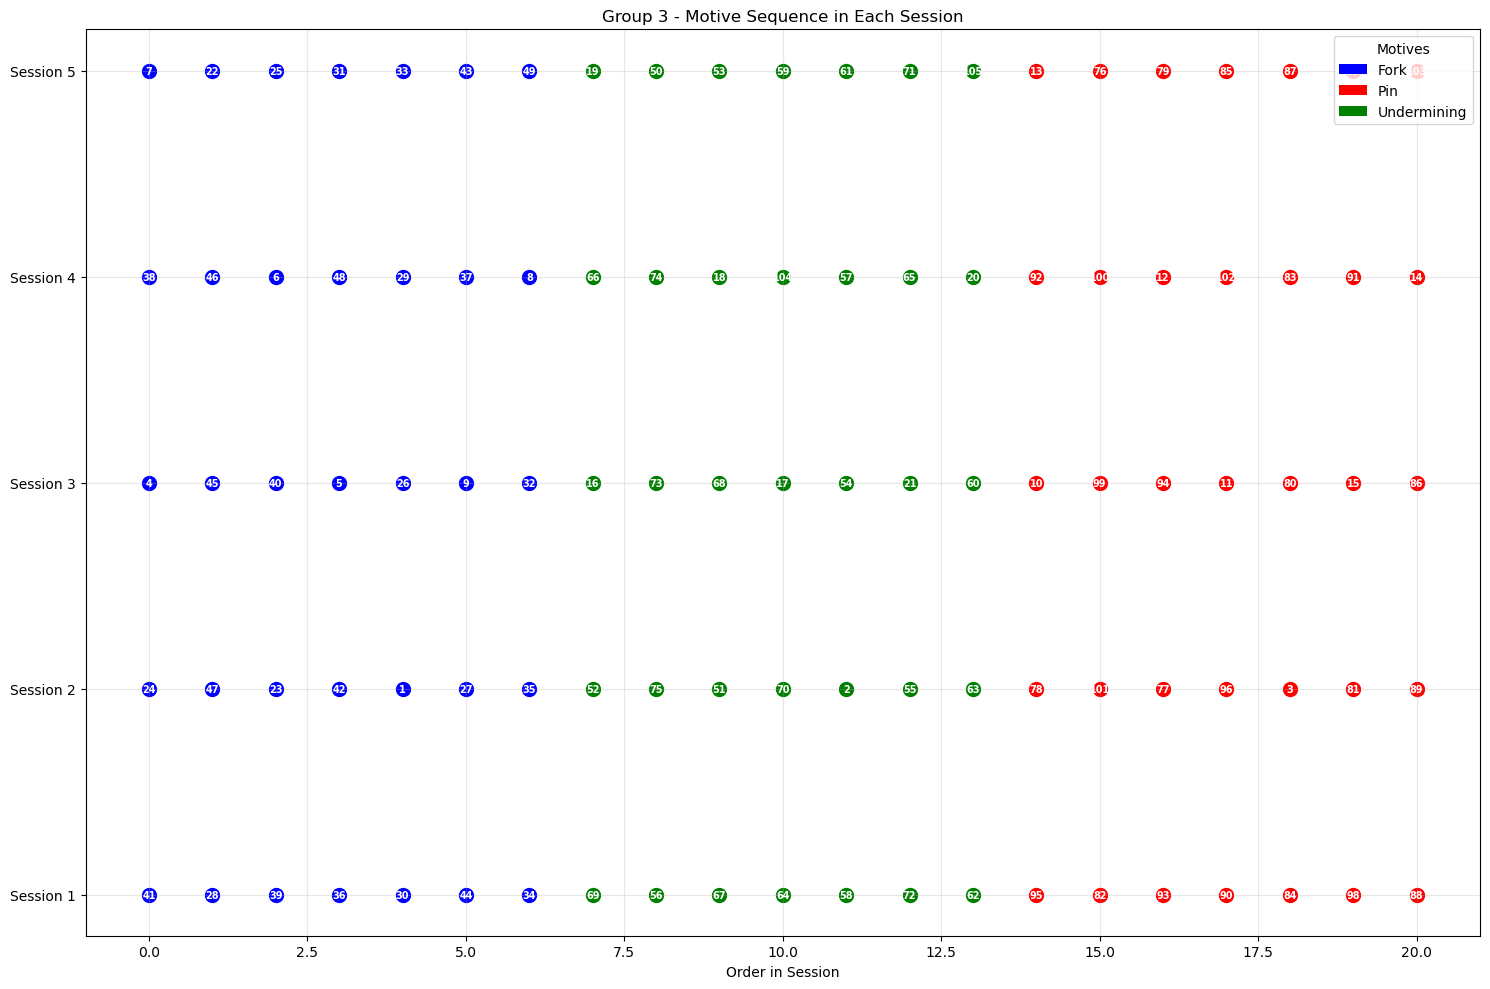

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Connect directly using sqlite3
conn = sqlite3.connect('chess_exercises.db')
cursor = conn.cursor()

try:
    print("Starting to fix exercise order in Group 3, Sessions 3, 4, and 5...")

    # 1. First, get the session IDs for Group 3, Sessions 3, 4, and 5
    cursor.execute("""
    SELECT id, session_number
    FROM sessions
    WHERE group_id = 3 AND session_number IN (3, 4, 5)
    """)

    session_ids = {row[1]: row[0] for row in cursor.fetchall()}
    print(f"Found session IDs: {session_ids}")

    if not session_ids:
        raise Exception("No sessions found for Group 3 with session numbers 3, 4, 5")

    # 2. Process each session
    for session_num in [3, 4, 5]:
        if session_num not in session_ids:
            print(f"Warning: No data found for Session {session_num}")
            continue

        session_id = session_ids[session_num]
        print(f"\nProcessing Session {session_num} (ID: {session_id})...")

        # Get current exercise order
        cursor.execute("""
        SELECT es.exercise_id, es.order_in_session, e.motives
        FROM exercise_sessions es
        JOIN exercises e ON es.exercise_id = e.id
        WHERE es.session_id = ?
        ORDER BY es.order_in_session
        """, (session_id,))

        exercises = []
        for row in cursor.fetchall():
            exercises.append({"exercise_id": row[0], "order": row[1], "motives": row[2]})

        # Group by motive
        fork_exercises = [ex for ex in exercises if ex["motives"] == "Fork"]
        undermining_exercises = [ex for ex in exercises if ex["motives"] == "Undermining"]
        pin_exercises = [ex for ex in exercises if ex["motives"] == "Pin"]

        print(f"Session {session_num} has:")
        print(f"  {len(fork_exercises)} Fork exercises")
        print(f"  {len(undermining_exercises)} Undermining exercises")
        print(f"  {len(pin_exercises)} Pin exercises")

        # Create new order: Fork-Undermining-Pin
        new_order = []
        order_index = 0

        # Add Fork exercises first
        for ex in fork_exercises:
            new_order.append((ex["exercise_id"], order_index))
            order_index += 1

        # Add Undermining exercises second
        for ex in undermining_exercises:
            new_order.append((ex["exercise_id"], order_index))
            order_index += 1

        # Add Pin exercises last
        for ex in pin_exercises:
            new_order.append((ex["exercise_id"], order_index))
            order_index += 1

        # Update exercise_sessions using direct SQL
        print(f"Updating {len(new_order)} exercises for Session {session_num}...")

        # Create a temporary table for this session
        cursor.execute("CREATE TEMPORARY TABLE temp_order (exercise_id INTEGER, new_order INTEGER)")

        # Insert the new order into the temporary table
        cursor.executemany("INSERT INTO temp_order VALUES (?, ?)", new_order)

        # Update the exercise_sessions table using the temporary table
        cursor.execute("""
        UPDATE exercise_sessions
        SET order_in_session = (
            SELECT new_order
            FROM temp_order
            WHERE temp_order.exercise_id = exercise_sessions.exercise_id
        )
        WHERE session_id = ?
        AND exercise_id IN (SELECT exercise_id FROM temp_order)
        """, (session_id,))

        # Drop the temporary table
        cursor.execute("DROP TABLE temp_order")

        print(f"Updated {cursor.rowcount} rows for Session {session_num}")

    # Commit changes
    conn.commit()
    print("Changes committed to database.")

    # 3. Verify the changes
    print("\nVerifying changes...")

    for session_num in [3, 4, 5]:
        if session_num not in session_ids:
            continue

        session_id = session_ids[session_num]
        cursor.execute("""
        SELECT es.exercise_id, es.order_in_session, e.motives
        FROM exercise_sessions es
        JOIN exercises e ON es.exercise_id = e.id
        WHERE es.session_id = ?
        ORDER BY es.order_in_session
        """, (session_id,))

        print(f"\nSession {session_num} new order:")
        motives_pattern = []

        for row in cursor.fetchall():
            exercise_id, order_in_session, motive = row
            print(f"  Order {order_in_session}: Exercise {exercise_id} - {motive}")
            motives_pattern.append(motive)

        # Check if pattern is correct
        print(f"\nSession {session_num} motive pattern:")
        print(" -> ".join(motives_pattern))

        # Find boundaries between motives
        fork_end = next((i for i, m in enumerate(motives_pattern) if m != "Fork"), -1)
        undermining_start = fork_end
        undermining_end = next((i for i, m in enumerate(motives_pattern[undermining_start:], undermining_start) if m != "Undermining"), -1)
        pin_start = undermining_end if undermining_end != -1 else len(motives_pattern)

        if fork_end > 0 and undermining_start == fork_end and undermining_end > undermining_start:
            print(f"Session {session_num} follows the Fork-Undermining-Pin pattern ✓")
        else:
            print(f"WARNING: Session {session_num} may not follow the Fork-Undermining-Pin pattern!")

    # 4. Create a visualization
    all_data = []
    for session_num in [1, 2, 3, 4, 5]:  # Include all sessions for Group 3
        if session_num not in session_ids and session_num > 2:
            continue

        # For sessions 1-2, we need to get their IDs
        if session_num <= 2:
            cursor.execute("SELECT id FROM sessions WHERE group_id = 3 AND session_number = ?", (session_num,))
            result = cursor.fetchone()
            if not result:
                continue
            session_id = result[0]
        else:
            session_id = session_ids[session_num]

        cursor.execute("""
        SELECT es.order_in_session, e.id, e.motives
        FROM exercise_sessions es
        JOIN exercises e ON es.exercise_id = e.id
        WHERE es.session_id = ?
        ORDER BY es.order_in_session
        """, (session_id,))

        for row in cursor.fetchall():
            all_data.append({
                "session_number": session_num,
                "order_in_session": row[0],
                "exercise_id": row[1],
                "motives": row[2]
            })

    # Convert to DataFrame
    viz_df = pd.DataFrame(all_data)

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Create a mapping of motives to colors - using consistent colors
    colors = {'Fork': 'blue', 'Undermining': 'green', 'Pin': 'red'}

    # Get unique sessions
    sessions = sorted(viz_df['session_number'].unique())

    # For each session, plot the sequence of motives
    for i, session in enumerate(sessions):
        session_data = viz_df[viz_df['session_number'] == session].sort_values('order_in_session')

        if session_data.empty:
            continue

        motives = session_data['motives'].tolist()

        # Plot each motive as a colored segment
        for j, motive in enumerate(motives):
            plt.scatter(j, i, color=colors[motive], s=100)

            # Add exercise ID as text
            exercise_id = session_data.iloc[j]['exercise_id']
            plt.text(j, i, str(exercise_id), ha='center', va='center', fontsize=7,
                     color='white', fontweight='bold')

    plt.yticks(range(len(sessions)), [f"Session {s}" for s in sessions])
    plt.xlabel("Order in Session")
    plt.title(f"Group 3 - Motive Sequence in Each Session")
    plt.grid(True, alpha=0.3)

    # Add legend
    legend_elements = [Patch(facecolor=colors[motive], label=motive)
                      for motive in sorted(colors.keys())]
    plt.legend(handles=legend_elements, title="Motives", loc='upper right')

    plt.tight_layout()
    plt.savefig('group3_motive_sequence_verification.png', dpi=300, bbox_inches='tight')

    print("Visualization saved as 'group3_motive_sequence_verification.png'")

    # Export data to CSV for verification
    viz_df.to_csv('group3_exercises.csv', index=False)
    print("Data exported to 'group3_exercises.csv' for manual verification")

except Exception as e:
    # Rollback in case of error
    conn.rollback()
    print(f"Error during exercise order correction: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Close the connection
    conn.close()

Group 1 has 105 exercises across 5 sessions
Group 2 has 105 exercises across 5 sessions
Group 3 has 105 exercises across 5 sessions
Group 4 has 105 exercises across 5 sessions


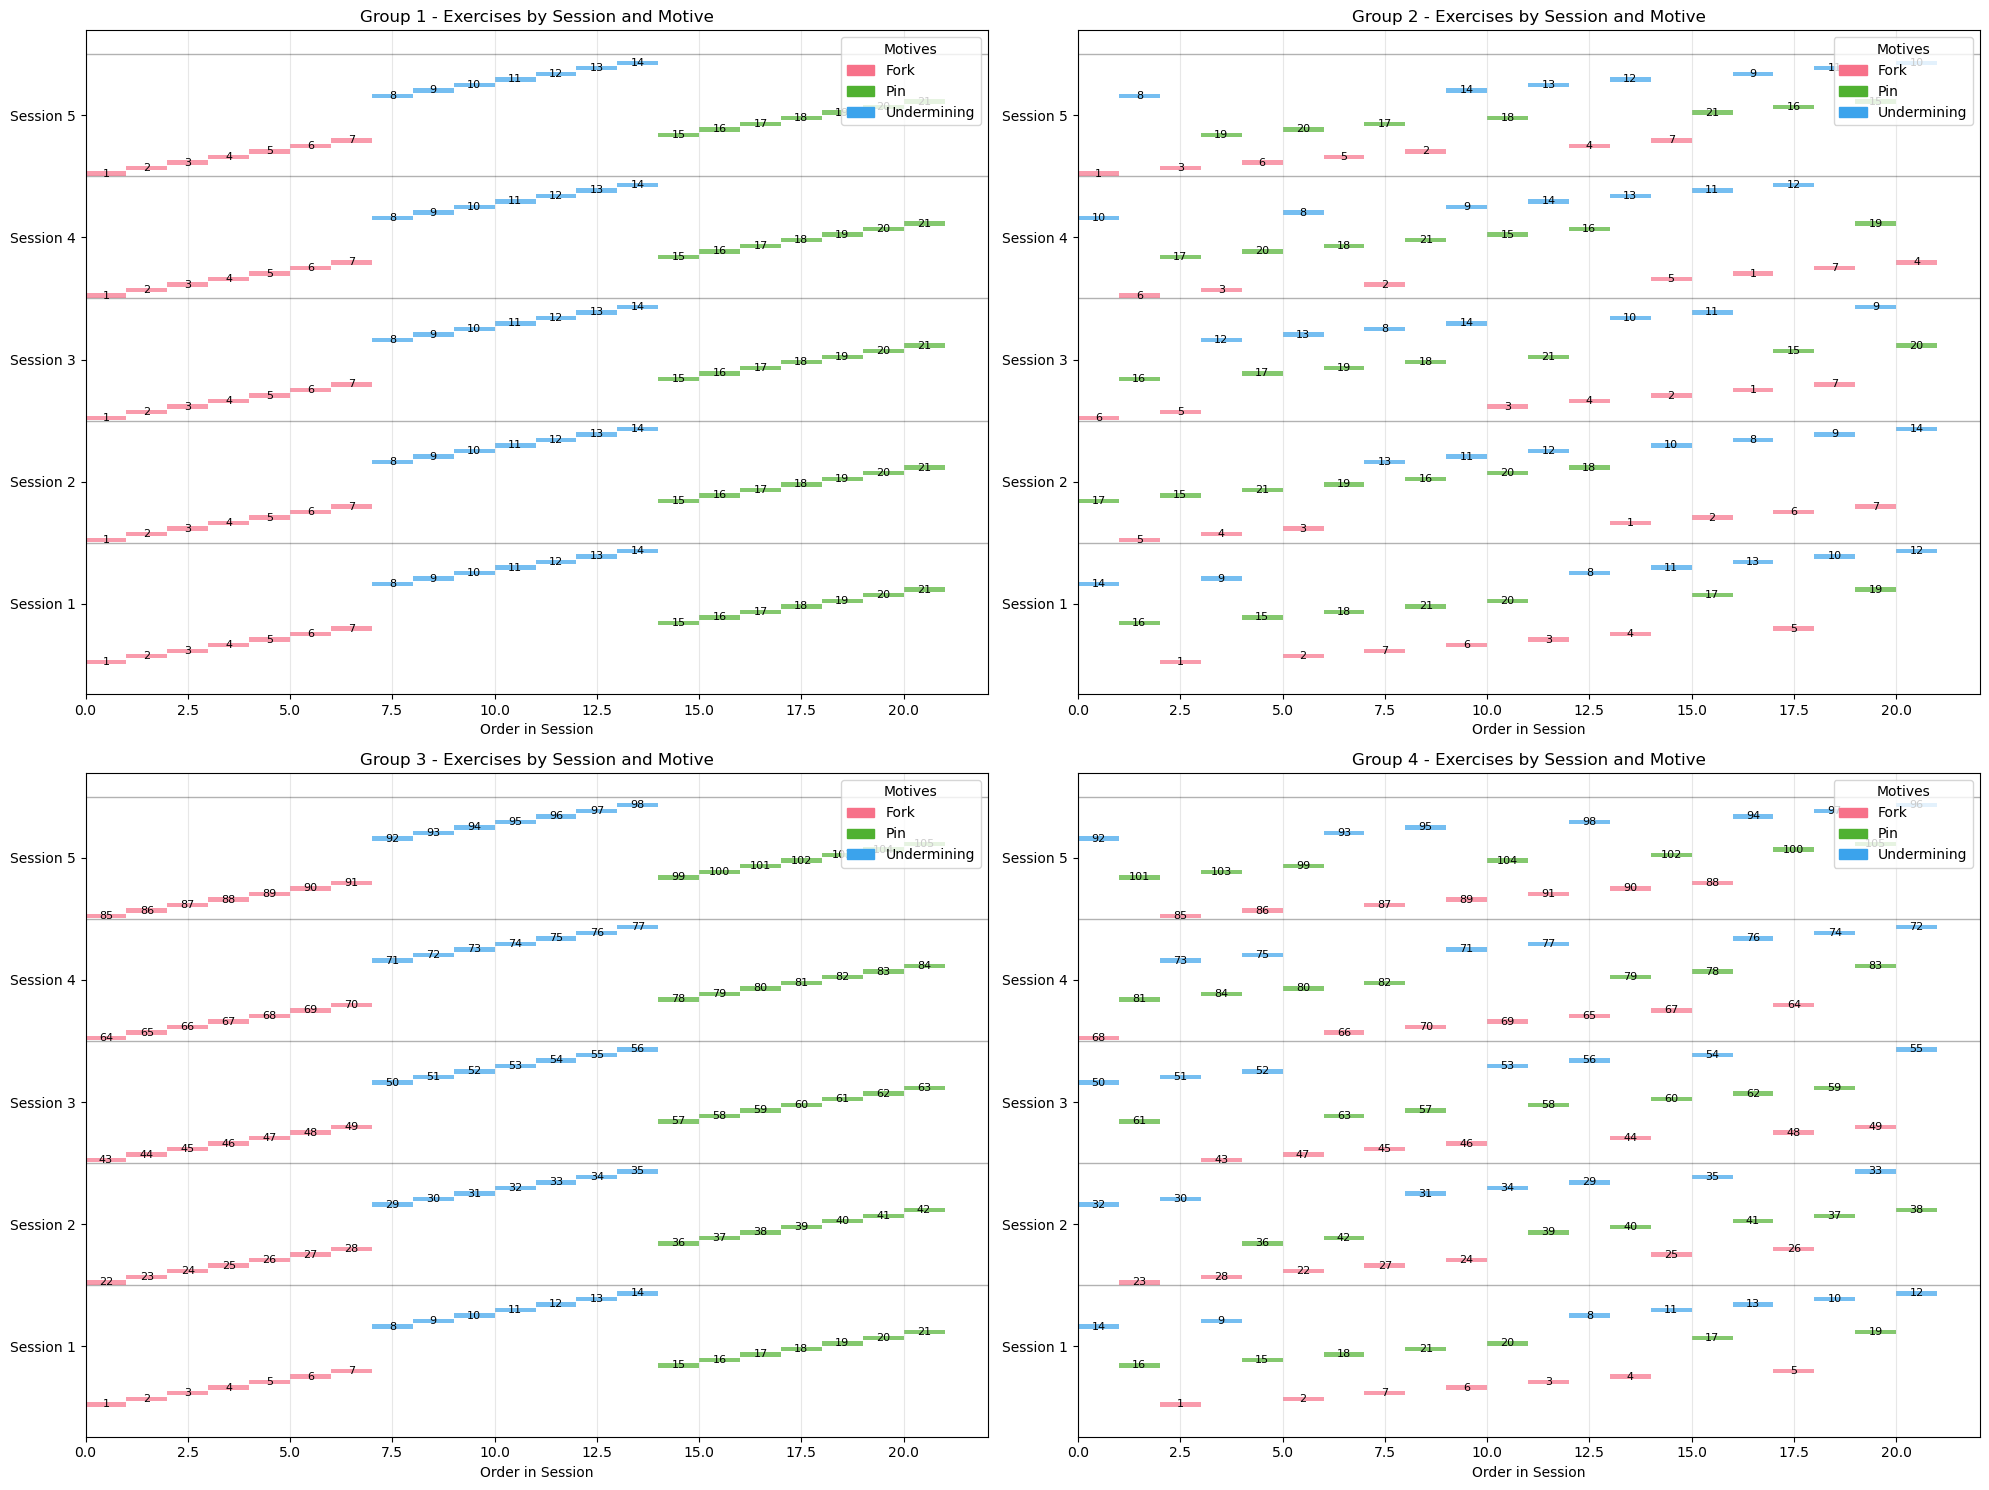

/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/2579969178.py:128: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1) if pd.notna(x) else -1)
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/2579969178.py:128: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1) if pd.notna(x) else -1)
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/2579969178.py:128: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1) if pd.notna(x) else -1)
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/2579969178.py:128: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: m

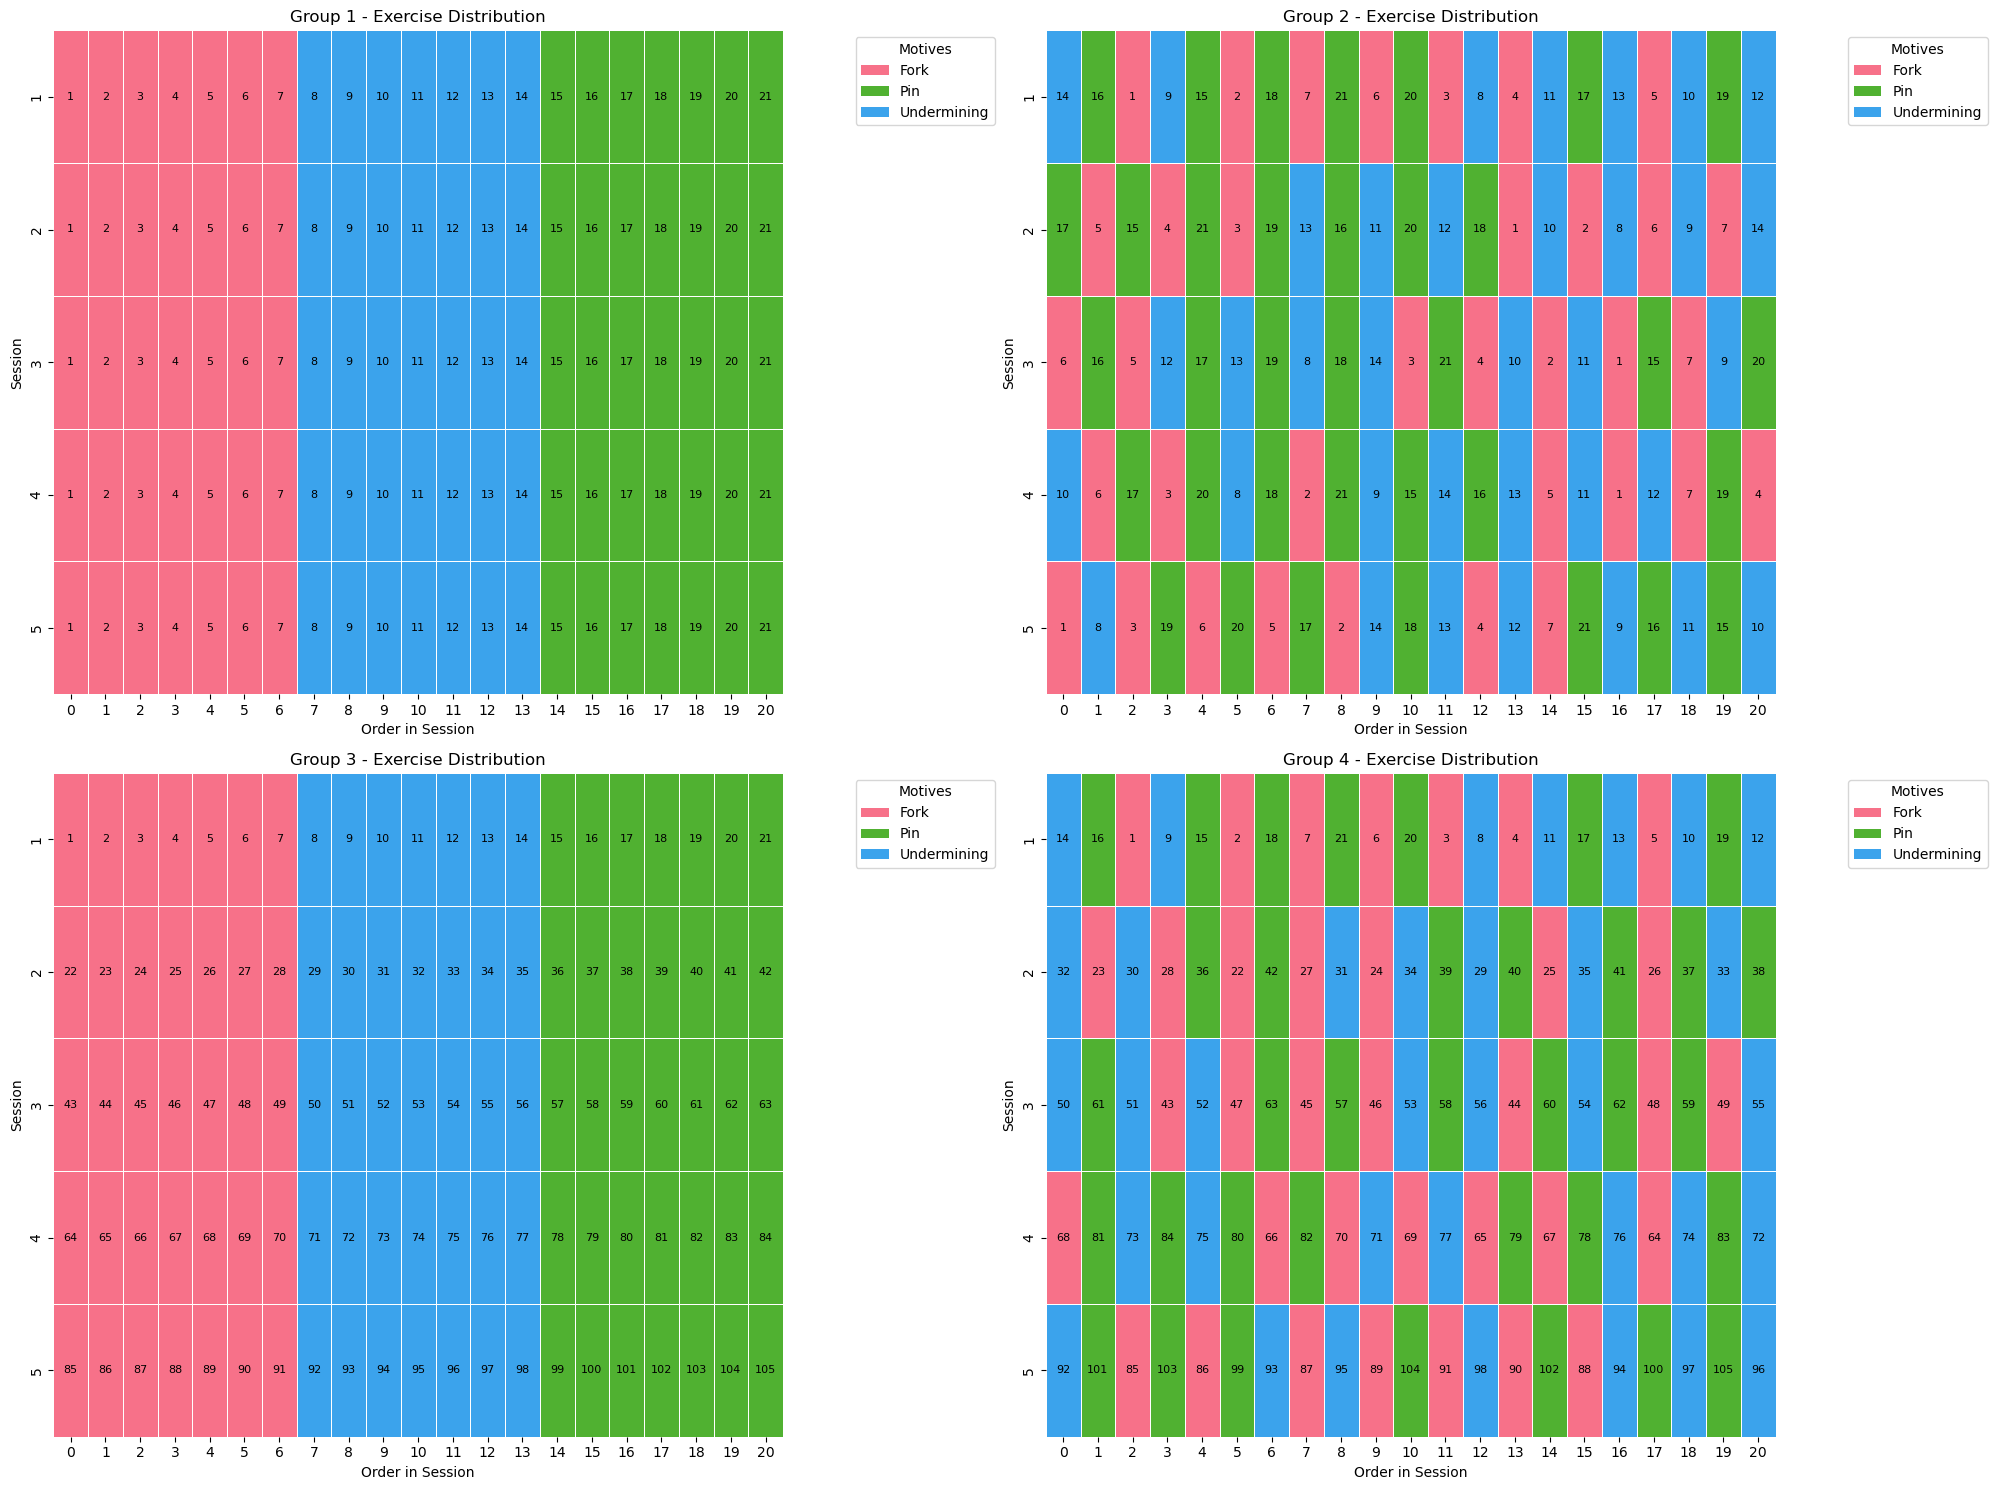

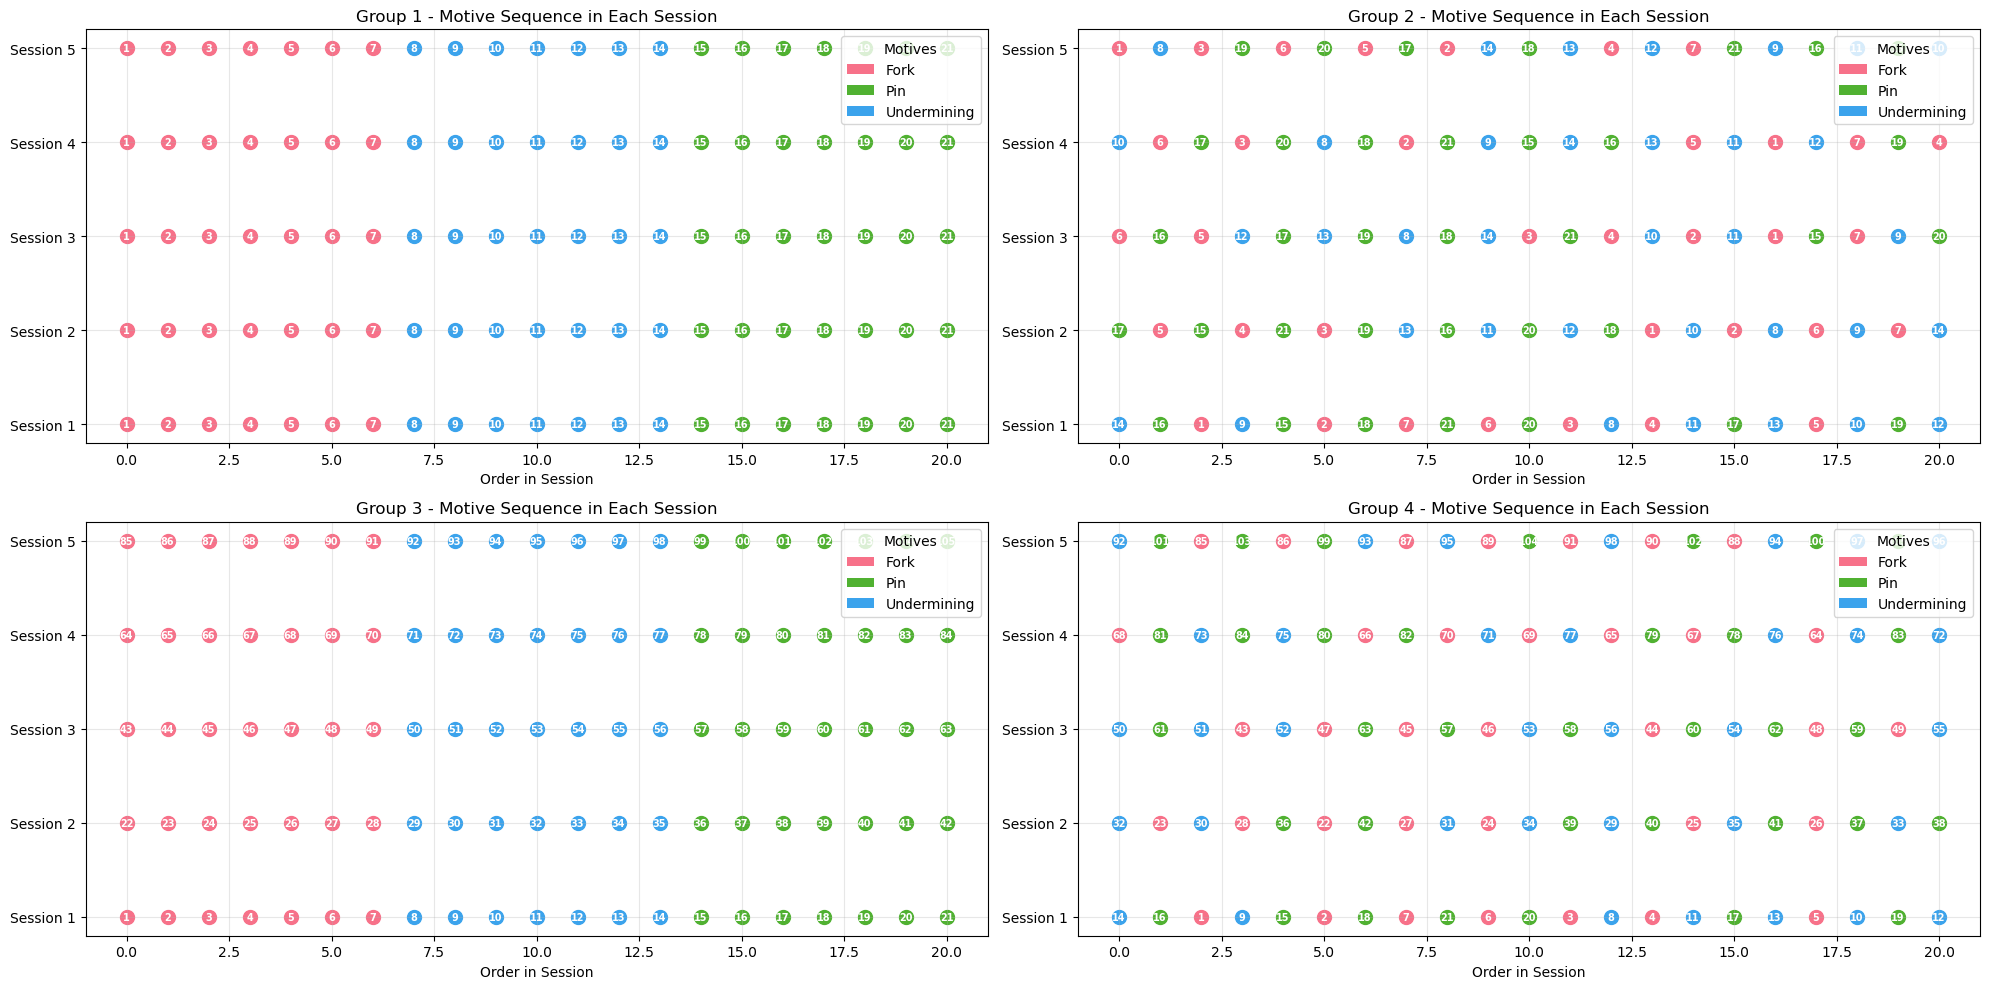

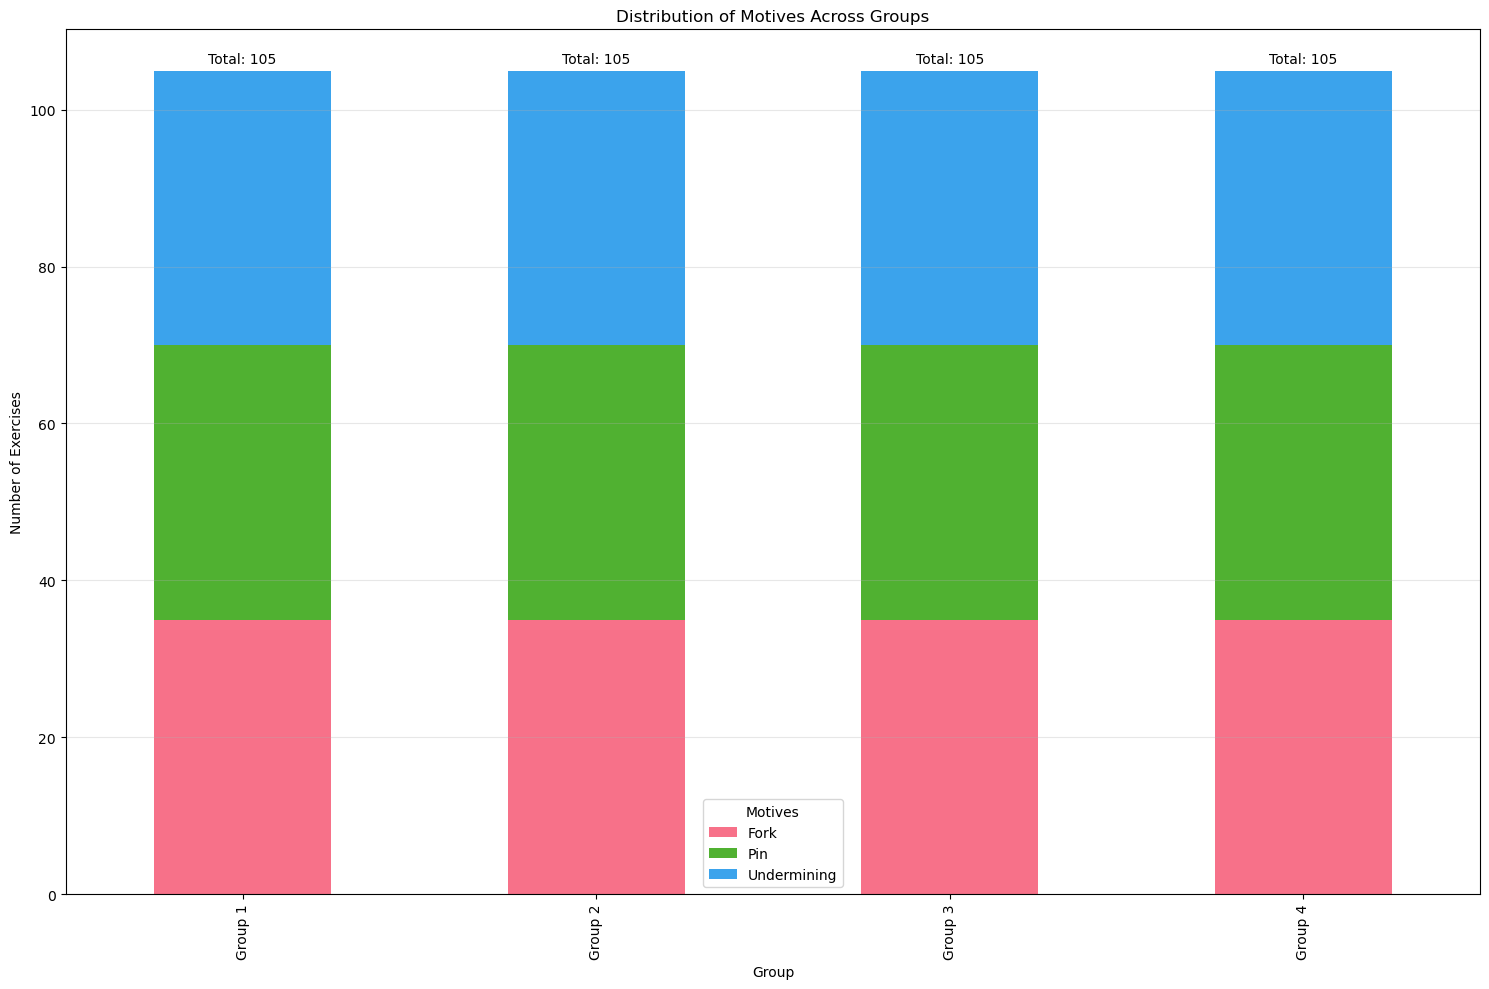

Visualizations created successfully!


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from matplotlib.patches import Patch

# Connect to the database
engine = create_engine('sqlite:///chess_exercises.db')
Session = sessionmaker(bind=engine)
db_session = Session()

try:
    # Query to get all exercise data with group, session, and order information
    query = """
    SELECT
        g.id as group_id,
        s.session_number,
        es.order_in_session,
        e.id as exercise_id,
        e.motives,
        e.initial_fen,
        e.moves,
        e.starting_color,
        e.created_at
    FROM groups g
    JOIN sessions s ON g.id = s.group_id
    JOIN exercise_sessions es ON s.id = es.session_id
    JOIN exercises e ON es.exercise_id = e.id
    ORDER BY g.id, s.session_number, es.order_in_session
    """

    # Execute the query and load into a DataFrame
    result = db_session.execute(text(query)).fetchall()
    columns = ['group_id', 'session_number', 'order_in_session', 'exercise_id',
               'motives', 'initial_fen', 'moves', 'starting_color', 'created_at']
    all_data = pd.DataFrame(result, columns=columns)

    # Group data by group_id
    groups_data = {}
    for group_id in range(1, 5):
        groups_data[group_id] = all_data[all_data['group_id'] == group_id].copy()
        print(f"Group {group_id} has {len(groups_data[group_id])} exercises across {groups_data[group_id]['session_number'].nunique()} sessions")

    # Create a color palette for motives
    all_motives = set(all_data['motives'].unique())
    colors = sns.color_palette("husl", len(all_motives))
    motive_color_map = dict(zip(sorted(all_motives), colors))

    # 1. Create bar chart visualization for each group
    plt.figure(figsize=(20, 15))

    for group_num, group_df in groups_data.items():
        plt.subplot(2, 2, group_num)

        # Sort by session and order_in_session
        group_df = group_df.sort_values(['session_number', 'order_in_session'])

        # Get unique sessions
        sessions = sorted(group_df['session_number'].unique())

        # Set up the plot
        y_positions = {}
        y_ticks = []
        y_labels = []

        current_y = 0

        # For each session
        for session in sessions:
            session_data = group_df[group_df['session_number'] == session]
            session_start_y = current_y

            # Group exercises by motive within the session
            for motive in sorted(session_data['motives'].unique()):
                motive_data = session_data[session_data['motives'] == motive]

                # Plot each exercise in this motive group
                for _, exercise in motive_data.iterrows():
                    plt.barh(current_y, 1, left=exercise['order_in_session'],
                             color=motive_color_map[motive], alpha=0.7)
                    plt.text(exercise['order_in_session'] + 0.5, current_y,
                             f"{exercise['exercise_id']}", va='center', ha='center', fontsize=8)
                    current_y += 1

            # Add session label
            y_ticks.append(session_start_y + (current_y - session_start_y) / 2)
            y_labels.append(f"Session {session}")

            # Add space between sessions
            current_y += 1
            plt.axhline(y=current_y-0.5, color='black', linestyle='-', alpha=0.3, linewidth=1)

        plt.yticks(y_ticks, y_labels)
        plt.title(f"Group {group_num} - Exercises by Session and Motive")
        plt.xlabel("Order in Session")
        plt.grid(axis='x', alpha=0.3)

        # Create a legend for motives
        legend_elements = [plt.Rectangle((0, 0), 1, 1, color=motive_color_map[motive])
                          for motive in sorted(motive_color_map.keys())]
        plt.legend(legend_elements, sorted(motive_color_map.keys()),
                  title="Motives", loc='upper right')

    plt.tight_layout()
    plt.savefig('group_visualization_from_db.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Create heatmap visualization for each group
    plt.figure(figsize=(20, 15))

    for group_num, group_df in groups_data.items():
        plt.subplot(2, 2, group_num)

        # Create a pivot table: sessions as rows, order_in_session as columns, motives as values
        pivot_data = group_df.pivot_table(
            index='session_number',
            columns='order_in_session',
            values='motives',
            aggfunc='first'
        )

        # Create a numeric representation for motives
        motive_to_num = {motive: i for i, motive in enumerate(sorted(all_motives))}

        # Convert motives to numbers for the heatmap
        numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1) if pd.notna(x) else -1)

        # Create the heatmap
        sns.heatmap(numeric_pivot, cmap=sns.color_palette("husl", len(all_motives)),
                    cbar=False, linewidths=0.5, linecolor='white')

        # Add exercise IDs as text in each cell
        for session in pivot_data.index:
            for order in pivot_data.columns:
                if pd.notna(pivot_data.loc[session, order]):
                    exercise = group_df[(group_df['session_number'] == session) &
                                       (group_df['order_in_session'] == order)]
                    if not exercise.empty:
                        plt.text(order + 0.5, session - 0.5,
                                 f"{exercise['exercise_id'].values[0]}",
                                 ha='center', va='center', fontsize=8)

        plt.title(f"Group {group_num} - Exercise Distribution")
        plt.xlabel("Order in Session")
        plt.ylabel("Session")

        # Create a custom colorbar legend for motives
        legend_elements = [Patch(facecolor=colors[i], label=motive)
                          for i, motive in enumerate(sorted(all_motives))]
        plt.legend(handles=legend_elements, title="Motives",
                  loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.savefig('group_heatmap_from_db.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Create a visualization to verify the order of motives in each session
    plt.figure(figsize=(20, 10))

    # Create a mapping of motives to colors for consistency
    motive_order = {'Fork': 0, 'Pin': 1, 'Undermining': 2}
    motive_colors = {motive: sns.color_palette("husl", 3)[motive_order.get(motive, 0)]
                    for motive in all_motives}

    # For each group, create a subplot showing the order of motives in each session
    for group_num, group_df in groups_data.items():
        plt.subplot(2, 2, group_num)

        # Get unique sessions
        sessions = sorted(group_df['session_number'].unique())

        # For each session, plot the sequence of motives
        for i, session in enumerate(sessions):
            session_data = group_df[group_df['session_number'] == session].sort_values('order_in_session')
            motives = session_data['motives'].tolist()

            # Plot each motive as a colored segment
            for j, motive in enumerate(motives):
                plt.scatter(j, i, color=motive_colors[motive], s=100)

                # Add exercise ID as text
                exercise_id = session_data.iloc[j]['exercise_id']
                plt.text(j, i, str(exercise_id), ha='center', va='center', fontsize=7,
                         color='white', fontweight='bold')

        plt.yticks(range(len(sessions)), [f"Session {s}" for s in sessions])
        plt.xlabel("Order in Session")
        plt.title(f"Group {group_num} - Motive Sequence in Each Session")
        plt.grid(True, alpha=0.3)

        # Add legend
        legend_elements = [Patch(facecolor=motive_colors[motive], label=motive)
                          for motive in sorted(motive_colors.keys())]
        plt.legend(handles=legend_elements, title="Motives", loc='upper right')

    plt.tight_layout()
    plt.savefig('motive_sequence_verification.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Create a summary visualization showing the distribution of motives across groups
    plt.figure(figsize=(15, 10))

    # Count exercises by group and motive
    motive_counts = all_data.groupby(['group_id', 'motives']).size().unstack().fillna(0)

    # Plot as a stacked bar chart
    motive_counts.plot(kind='bar', stacked=True, ax=plt.gca(),
                      color=[motive_colors[m] for m in motive_counts.columns])

    plt.title('Distribution of Motives Across Groups')
    plt.xlabel('Group')
    plt.ylabel('Number of Exercises')
    plt.xticks(range(len(motive_counts)), [f"Group {g}" for g in motive_counts.index])
    plt.legend(title='Motives')
    plt.grid(axis='y', alpha=0.3)

    # Add total count labels on top of each bar
    for i, total in enumerate(motive_counts.sum(axis=1)):
        plt.text(i, total + 1, f"Total: {int(total)}", ha='center')

    plt.tight_layout()
    plt.savefig('motive_distribution_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

finally:
    # Close the session
    db_session.close()

print("Visualizations created successfully!")

Working with database: /Users/tomaszkoczar/Desktop/Studia/Chessv2/backend/instance/chess_exercises.db
Database tables:
  - exercises
  - groups
  - sessions
  - exercise_sessions
  - exercises_backup
  - exercise_sessions_backup
  - id_mapping

Database contains:
  - 105 exercises
  - 4 groups
  - 20 sessions
  - 420 exercise-session mappings

Exercise distribution:
  - Group 1, Session 1: 21 exercises
  - Group 1, Session 2: 21 exercises
  - Group 1, Session 3: 21 exercises
  - Group 1, Session 4: 21 exercises
  - Group 1, Session 5: 21 exercises
  - Group 2, Session 1: 21 exercises
  - Group 2, Session 2: 21 exercises
  - Group 2, Session 3: 21 exercises
  - Group 2, Session 4: 21 exercises
  - Group 2, Session 5: 21 exercises
  - Group 3, Session 1: 21 exercises
  - Group 3, Session 2: 21 exercises
  - Group 3, Session 3: 21 exercises
  - Group 3, Session 4: 21 exercises
  - Group 3, Session 5: 21 exercises
  - Group 4, Session 1: 21 exercises
  - Group 4, Session 2: 21 exercises
  

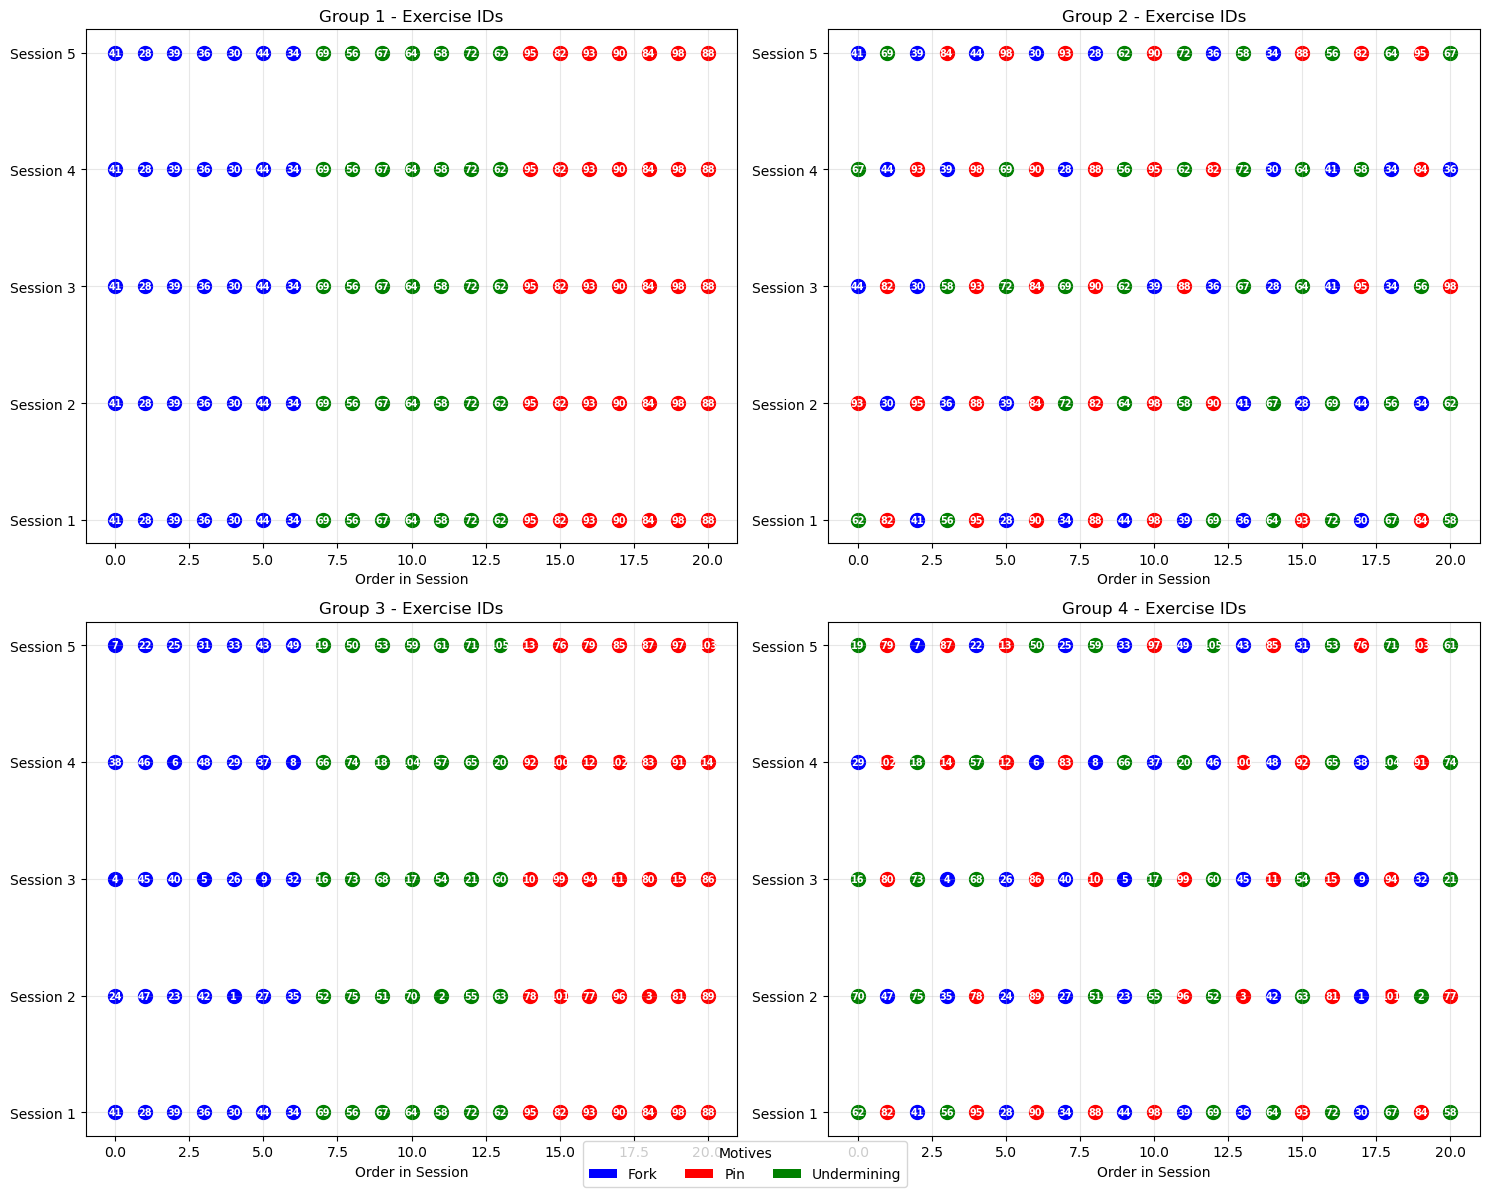

In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os

# Path to the database
db_path = 'chess_exercises.db'

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

try:
    print(f"Working with database: {os.path.abspath(db_path)}")

    # First, let's understand the database structure
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = cursor.fetchall()
    print("Database tables:")
    for table in tables:
        print(f"  - {table[0]}")

    # Check how many exercises, groups, sessions we have
    cursor.execute("SELECT COUNT(*) FROM exercises")
    total_exercises = cursor.fetchone()[0]

    cursor.execute("SELECT COUNT(*) FROM groups")
    total_groups = cursor.fetchone()[0]

    cursor.execute("SELECT COUNT(*) FROM sessions")
    total_sessions = cursor.fetchone()[0]

    cursor.execute("SELECT COUNT(*) FROM exercise_sessions")
    total_mappings = cursor.fetchone()[0]

    print(f"\nDatabase contains:")
    print(f"  - {total_exercises} exercises")
    print(f"  - {total_groups} groups")
    print(f"  - {total_sessions} sessions")
    print(f"  - {total_mappings} exercise-session mappings")

    # Get the current distribution of exercises across groups and sessions
    cursor.execute("""
    SELECT
        g.id as group_id,
        s.session_number,
        COUNT(es.exercise_id) as exercise_count
    FROM groups g
    JOIN sessions s ON g.id = s.group_id
    JOIN exercise_sessions es ON s.id = es.session_id
    GROUP BY g.id, s.session_number
    ORDER BY g.id, s.session_number
    """)

    distribution = cursor.fetchall()
    print("\nExercise distribution:")
    for group_id, session_number, count in distribution:
        print(f"  - Group {group_id}, Session {session_number}: {count} exercises")

    # Create backup tables before modifying data
    print("\nCreating backup tables...")
    cursor.execute("DROP TABLE IF EXISTS exercises_backup")
    cursor.execute("CREATE TABLE exercises_backup AS SELECT * FROM exercises")

    cursor.execute("DROP TABLE IF EXISTS exercise_sessions_backup")
    cursor.execute("CREATE TABLE exercise_sessions_backup AS SELECT * FROM exercise_sessions")

    conn.commit()
    print("Backup tables created.")

    # Get all exercises with their group, session, and order information
    cursor.execute("""
    SELECT
        e.id as original_id,
        g.id as group_id,
        s.session_number,
        es.order_in_session,
        e.initial_fen,
        e.moves,
        e.starting_color,
        e.motives,
        e.created_at,
        s.id as session_id
    FROM exercises e
    JOIN exercise_sessions es ON e.id = es.exercise_id
    JOIN sessions s ON es.session_id = s.id
    JOIN groups g ON s.group_id = g.id
    ORDER BY g.id, s.session_number, es.order_in_session
    """)

    all_exercises = cursor.fetchall()
    columns = ['original_id', 'group_id', 'session_number', 'order_in_session',
               'initial_fen', 'moves', 'starting_color', 'motives', 'created_at', 'session_id']

    df = pd.DataFrame(all_exercises, columns=columns)

    # Calculate new IDs based on group, session, and order
    # Start with ID 1 for Group 1, Session 1, and increment
    df['new_id'] = 0
    current_id = 1

    for group_id in sorted(df['group_id'].unique()):
        group_df = df[df['group_id'] == group_id]

        for session_number in sorted(group_df['session_number'].unique()):
            session_df = group_df[group_df['session_number'] == session_number]

            # Sort by order_in_session to ensure exercises are in the correct order
            session_df = session_df.sort_values('order_in_session')

            # Assign new IDs sequentially
            for idx, original_idx in enumerate(session_df.index):
                df.loc[original_idx, 'new_id'] = current_id
                current_id += 1

    # Print a sample of the ID mapping
    print("\nID mapping sample (first 10 exercises):")
    for _, row in df.head(10).iterrows():
        print(f"  - Exercise {row['original_id']} -> {row['new_id']} (Group {row['group_id']}, Session {row['session_number']}, Order {row['order_in_session']})")

    # Verify new ID assignments
    print("\nNew ID distribution:")
    for group_id in sorted(df['group_id'].unique()):
        group_df = df[df['group_id'] == group_id]

        for session_number in sorted(group_df['session_number'].unique()):
            session_df = group_df[group_df['session_number'] == session_number]
            min_id = session_df['new_id'].min()
            max_id = session_df['new_id'].max()
            print(f"  - Group {group_id}, Session {session_number}: IDs {min_id}-{max_id} ({len(session_df)} exercises)")

    # Prepare for database update
    print("\nPreparing for database update...")

    # Create mapping table
    cursor.execute("DROP TABLE IF EXISTS id_mapping")
    cursor.execute("CREATE TABLE id_mapping (old_id INTEGER, new_id INTEGER)")
    cursor.executemany("INSERT INTO id_mapping VALUES (?, ?)",
                      df[['original_id', 'new_id']].values)

    # Update process using temporary IDs to avoid conflicts
    print("Updating exercise_sessions with temporary IDs...")
    cursor.execute("""
    UPDATE exercise_sessions
    SET exercise_id = exercise_id + 10000
    WHERE exercise_id IN (SELECT old_id FROM id_mapping)
    """)

    print("Updating exercises with temporary IDs...")
    cursor.execute("""
    UPDATE exercises
    SET id = id + 10000
    WHERE id IN (SELECT old_id FROM id_mapping)
    """)

    # Now update to final new IDs
    print("Updating exercises with new IDs...")
    cursor.execute("""
    UPDATE exercises
    SET id = (
        SELECT new_id
        FROM id_mapping
        WHERE old_id = exercises.id - 10000
    )
    WHERE id > 10000
    """)

    print("Updating exercise_sessions references...")
    cursor.execute("""
    UPDATE exercise_sessions
    SET exercise_id = (
        SELECT new_id
        FROM id_mapping
        WHERE old_id = exercise_sessions.exercise_id - 10000
    )
    WHERE exercise_id > 10000
    """)

    # Commit changes
    conn.commit()
    print("Database update completed and committed.")

    # Verify the updates
    cursor.execute("""
    SELECT
        e.id,
        g.id as group_id,
        s.session_number,
        es.order_in_session,
        e.motives
    FROM exercises e
    JOIN exercise_sessions es ON e.id = es.exercise_id
    JOIN sessions s ON es.session_id = s.id
    JOIN groups g ON s.group_id = g.id
    ORDER BY e.id
    """)

    updated_exercises = cursor.fetchall()
    updated_df = pd.DataFrame(updated_exercises,
                             columns=['id', 'group_id', 'session_number', 'order_in_session', 'motives'])

    print("\nVerification - First 10 exercises after update:")
    for _, row in updated_df.head(10).iterrows():
        print(f"  - ID {row['id']}: Group {row['group_id']}, Session {row['session_number']}, Order {row['order_in_session']}, Motive: {row['motives']}")

    # Export to CSV for verification
    updated_df.to_csv('updated_exercises.csv', index=False)
    print("Updated exercise data exported to 'updated_exercises.csv'")

    # Create a visualization to verify the new ID structure
    plt.figure(figsize=(15, 12))

    # Create a mapping of motives to colors
    all_motives = updated_df['motives'].unique()
    colors = {'Fork': 'blue', 'Undermining': 'green', 'Pin': 'red'}

    # Create subplots for each group
    for group_id in sorted(updated_df['group_id'].unique()):
        group_df = updated_df[updated_df['group_id'] == group_id]

        plt.subplot(2, 2, group_id)

        # Get unique sessions for this group
        sessions = sorted(group_df['session_number'].unique())

        # For each session, plot the sequence of motives with new IDs
        for i, session in enumerate(sessions):
            session_df = group_df[group_df['session_number'] == session].sort_values('order_in_session')

            # Plot each exercise
            for j, (_, row) in enumerate(session_df.iterrows()):
                plt.scatter(j, i, color=colors.get(row['motives'], 'gray'), s=100)
                plt.text(j, i, str(row['id']), ha='center', va='center', fontsize=7,
                         color='white', fontweight='bold')

        plt.yticks(range(len(sessions)), [f"Session {s}" for s in sessions])
        plt.xlabel("Order in Session")
        plt.title(f"Group {group_id} - Exercise IDs")
        plt.grid(True, alpha=0.3)

    # Add a legend
    plt.figlegend(
        [Patch(facecolor=colors[motive]) for motive in sorted(colors.keys())],
        sorted(colors.keys()),
        title="Motives",
        loc='upper center',
        bbox_to_anchor=(0.5, 0.05),
        ncol=3
    )

    plt.tight_layout()
    plt.savefig('updated_exercises_visualization.png', dpi=300, bbox_inches='tight')

    print("Visualization saved as 'updated_exercises_visualization.png'")

except Exception as e:
    # Rollback in case of error
    conn.rollback()
    print(f"Error during ID renumbering: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Close the connection
    conn.close()

In [21]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Connect to the database
conn = sqlite3.connect('chess_exercises.db')
cursor = conn.cursor()

try:
    print("Starting to renumber exercises in Group 3...")

    # 1. First, check if the sequence_num column exists, and add it if not
    cursor.execute("PRAGMA table_info(exercises)")
    columns = [column[1] for column in cursor.fetchall()]

    if 'sequence_num' not in columns:
        print("Adding sequence_num column to exercises table...")
        cursor.execute("ALTER TABLE exercises ADD COLUMN sequence_num INTEGER")

    # 2. Get all exercises from Group 3 with their session and order
    cursor.execute("""
    SELECT
        e.id as current_id,
        s.session_number,
        es.order_in_session,
        s.id as session_id
    FROM exercises e
    JOIN exercise_sessions es ON e.id = es.exercise_id
    JOIN sessions s ON es.session_id = s.id
    WHERE s.group_id = 3
    ORDER BY s.session_number, es.order_in_session
    """)

    group3_exercises = cursor.fetchall()
    columns = ['current_id', 'session_number', 'order_in_session', 'session_id']

    df = pd.DataFrame(group3_exercises, columns=columns)

    # 3. Calculate sequence numbers starting from 1
    df['sequence_num'] = 0
    sequence_start = 1

    for session_num in sorted(df['session_number'].unique()):
        session_df = df[df['session_number'] == session_num]
        session_df = session_df.sort_values('order_in_session')

        for idx, row_idx in enumerate(session_df.index):
            df.loc[row_idx, 'sequence_num'] = sequence_start + idx

        # Update sequence_start for next session
        sequence_start += len(session_df)

    # Print mapping
    print("\nSequence number mapping (first 10 exercises):")
    for _, row in df.head(10).iterrows():
        print(f"  Exercise ID {row['current_id']} -> Sequence {row['sequence_num']} (Session {row['session_number']}, Order {row['order_in_session']})")

    print(f"...and {len(df) - 10} more exercises")

    # 6. Update the sequence_num field in the exercises table
    print("\nUpdating sequence_num in exercises table...")
    for _, row in df.iterrows():
        cursor.execute("""
        UPDATE exercises
        SET sequence_num = ?
        WHERE id = ?
        """, (row['sequence_num'], row['current_id']))
    conn.commit()
    # Commit changes
    print("ID updates committed to database.")

except Exception as e:
    # Rollback in case of error
    conn.rollback()
    print(f"Error during ID renumbering: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Close the connection
    conn.close()

Starting to renumber exercises in Group 3...

Sequence number mapping (first 10 exercises):
  Exercise ID 41 -> Sequence 1 (Session 1, Order 0)
  Exercise ID 28 -> Sequence 2 (Session 1, Order 1)
  Exercise ID 39 -> Sequence 3 (Session 1, Order 2)
  Exercise ID 36 -> Sequence 4 (Session 1, Order 3)
  Exercise ID 30 -> Sequence 5 (Session 1, Order 4)
  Exercise ID 44 -> Sequence 6 (Session 1, Order 5)
  Exercise ID 34 -> Sequence 7 (Session 1, Order 6)
  Exercise ID 69 -> Sequence 8 (Session 1, Order 7)
  Exercise ID 56 -> Sequence 9 (Session 1, Order 8)
  Exercise ID 67 -> Sequence 10 (Session 1, Order 9)
...and 95 more exercises

Updating sequence_num in exercises table...
ID updates committed to database.


Starting to renumber exercises in Group 3...
Exercises per session in Group 3:
  Session 1: 21 exercises
  Session 2: 21 exercises
  Session 3: 21 exercises
  Session 4: 21 exercises
  Session 5: 21 exercises

ID mapping (first 10 exercises):
  Exercise 41 -> 1 (Session 1, Order 0)
  Exercise 28 -> 2 (Session 1, Order 1)
  Exercise 39 -> 3 (Session 1, Order 2)
  Exercise 36 -> 4 (Session 1, Order 3)
  Exercise 30 -> 5 (Session 1, Order 4)
  Exercise 44 -> 6 (Session 1, Order 5)
  Exercise 34 -> 7 (Session 1, Order 6)
  Exercise 69 -> 8 (Session 1, Order 7)
  Exercise 56 -> 9 (Session 1, Order 8)
  Exercise 67 -> 10 (Session 1, Order 9)
...and 95 more exercises

Planned ID ranges for Group 3:
  Session 1: IDs 1-21 (21 exercises)
  Session 2: IDs 22-42 (21 exercises)
  Session 3: IDs 43-63 (21 exercises)
  Session 4: IDs 64-84 (21 exercises)
  Session 5: IDs 85-105 (21 exercises)

Creating backup tables...
Backup tables created.
Starting ID update process...
Updating to temporary high ID

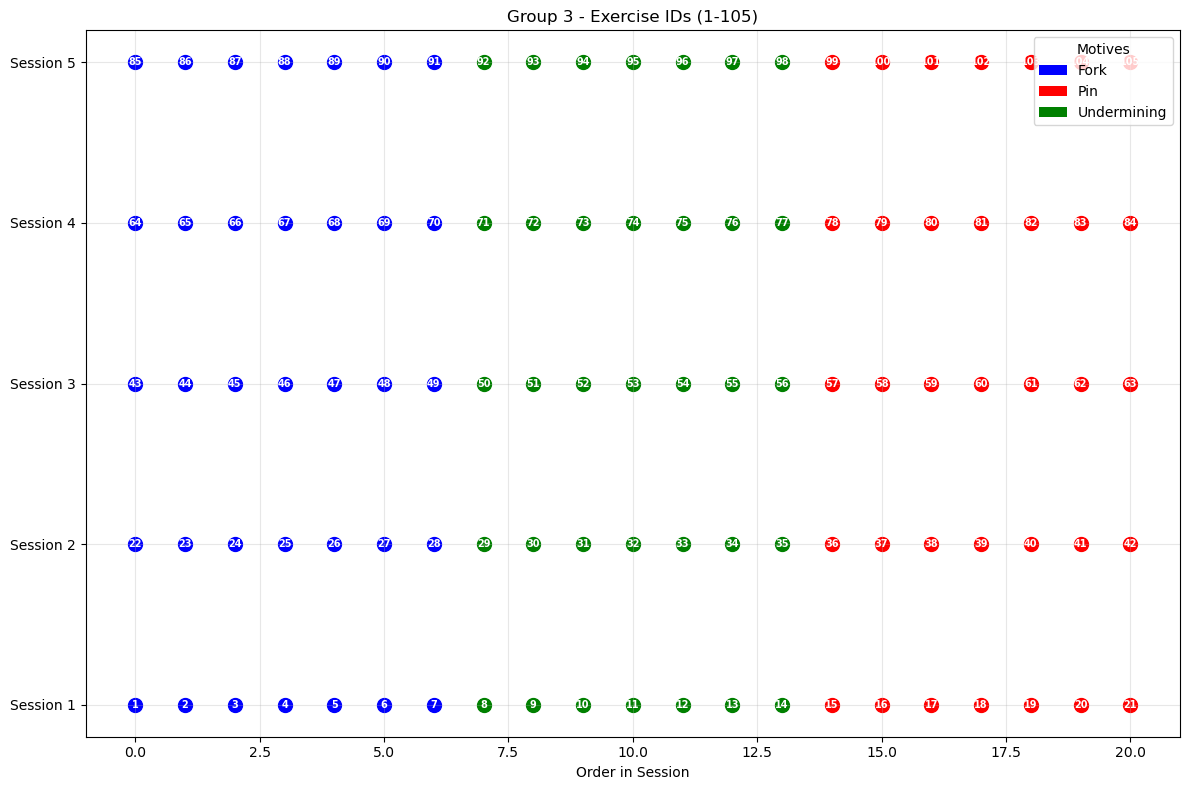

In [22]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Connect to the database
conn = sqlite3.connect('chess_exercises.db')
cursor = conn.cursor()

try:
    print("Starting to renumber exercises in Group 3...")

    # 1. Get all exercises from Group 3 with their session and order
    cursor.execute("""
    SELECT
        e.id as current_id,
        s.session_number,
        es.order_in_session,
        e.initial_fen,
        e.moves,
        e.starting_color,
        e.motives,
        e.created_at,
        s.id as session_id,
        es.id as exercise_session_id
    FROM exercises e
    JOIN exercise_sessions es ON e.id = es.exercise_id
    JOIN sessions s ON es.session_id = s.id
    WHERE s.group_id = 3
    ORDER BY s.session_number, es.order_in_session
    """)

    group3_exercises = cursor.fetchall()
    columns = ['current_id', 'session_number', 'order_in_session', 'initial_fen',
               'moves', 'starting_color', 'motives', 'created_at', 'session_id', 'exercise_session_id']

    df = pd.DataFrame(group3_exercises, columns=columns)

    # Count exercises per session to verify
    exercises_per_session = df.groupby('session_number').size()
    print("Exercises per session in Group 3:")
    for session, count in exercises_per_session.items():
        print(f"  Session {session}: {count} exercises")

    # 2. Calculate new IDs based on session and position (1-105)
    df['new_id'] = 0

    for session in sorted(df['session_number'].unique()):
        # Calculate the start ID for this session
        start_id = (session - 1) * 21 + 1

        # Get exercises for this session
        session_mask = df['session_number'] == session
        session_exercises = df[session_mask].sort_values('order_in_session')

        # Assign sequential IDs
        for idx, row_idx in enumerate(session_exercises.index):
            df.loc[row_idx, 'new_id'] = start_id + idx

    # Print mapping of current to new IDs
    print("\nID mapping (first 10 exercises):")
    for _, row in df.head(10).iterrows():
        print(f"  Exercise {row['current_id']} -> {row['new_id']} (Session {row['session_number']}, Order {row['order_in_session']})")

    print(f"...and {len(df) - 10} more exercises")

    # Store the original and new IDs for all Group 3 exercises
    id_map = dict(zip(df['current_id'], df['new_id']))

    # Verify the planned ID range for each session
    print("\nPlanned ID ranges for Group 3:")
    for session in sorted(df['session_number'].unique()):
        session_df = df[df['session_number'] == session]
        min_id = session_df['new_id'].min()
        max_id = session_df['new_id'].max()
        print(f"  Session {session}: IDs {min_id}-{max_id} ({len(session_df)} exercises)")

    # 3. Create backups before making changes
    print("\nCreating backup tables...")
    cursor.execute("DROP TABLE IF EXISTS exercises_backup_group3")
    cursor.execute("CREATE TABLE exercises_backup_group3 AS SELECT * FROM exercises")

    cursor.execute("DROP TABLE IF EXISTS exercise_sessions_backup_group3")
    cursor.execute("CREATE TABLE exercise_sessions_backup_group3 AS SELECT * FROM exercise_sessions")

    conn.commit()
    print("Backup tables created.")

    # 4. Apply updates using temporary high IDs to avoid conflicts
    print("Starting ID update process...")

    # First, we need all exercise_session entries that reference our Group 3 exercises
    cursor.execute("""
    SELECT es.id, es.exercise_id, es.session_id, es.order_in_session
    FROM exercise_sessions es
    WHERE es.exercise_id IN (
        SELECT e.id
        FROM exercises e
        JOIN exercise_sessions es2 ON e.id = es2.exercise_id
        JOIN sessions s ON es2.session_id = s.id
        WHERE s.group_id = 3
    )
    """)

    all_references = cursor.fetchall()
    ref_df = pd.DataFrame(all_references, columns=['id', 'exercise_id', 'session_id', 'order_in_session'])

    # Map the new IDs to all references (including those outside Group 3)
    ref_df['new_exercise_id'] = ref_df['exercise_id'].map(id_map)

    # 5. Update to temporary high IDs
    print("Updating to temporary high IDs...")

    # Update exercise_sessions to use temporary high IDs
    for old_id, new_id in id_map.items():
        cursor.execute("""
        UPDATE exercise_sessions
        SET exercise_id = ?
        WHERE exercise_id = ?
        """, (old_id + 10000, old_id))

    # Update exercises to use temporary high IDs
    for old_id in id_map.keys():
        cursor.execute("""
        UPDATE exercises
        SET id = ?
        WHERE id = ?
        """, (old_id + 10000, old_id))

    # 6. Update to final new IDs
    print("Updating to final new IDs...")

    # Update exercises
    for old_id, new_id in id_map.items():
        cursor.execute("""
        UPDATE exercises
        SET id = ?
        WHERE id = ?
        """, (new_id, old_id + 10000))

    # Update exercise_sessions
    for old_id, new_id in id_map.items():
        cursor.execute("""
        UPDATE exercise_sessions
        SET exercise_id = ?
        WHERE exercise_id = ?
        """, (new_id, old_id + 10000))

    # Commit changes
    conn.commit()
    print("ID update completed and committed.")

    # 7. Verify the changes
    cursor.execute("""
    SELECT
        e.id,
        s.session_number,
        es.order_in_session,
        e.motives
    FROM exercises e
    JOIN exercise_sessions es ON e.id = es.exercise_id
    JOIN sessions s ON es.session_id = s.id
    WHERE s.group_id = 3
    ORDER BY e.id
    """)

    updated_exercises = cursor.fetchall()
    updated_df = pd.DataFrame(updated_exercises,
                             columns=['id', 'session_number', 'order_in_session', 'motives'])

    # 8. Check for sequential ID ranges by session
    print("\nVerifying updated ID ranges for Group 3:")
    for session in sorted(updated_df['session_number'].unique()):
        session_df = updated_df[updated_df['session_number'] == session]
        min_id = session_df['id'].min()
        max_id = session_df['id'].max()
        print(f"  Session {session}: IDs {min_id}-{max_id} ({len(session_df)} exercises)")

        # Check for continuity
        expected_ids = set(range(min_id, max_id + 1))
        actual_ids = set(session_df['id'])
        if expected_ids == actual_ids:
            print(f"    ✓ IDs are continuous")
        else:
            missing = expected_ids - actual_ids
            print(f"    ! Missing IDs: {missing}")

    # Export updated data to CSV
    updated_df.to_csv('group3_updated_ids.csv', index=False)
    print("Updated data exported to 'group3_updated_ids.csv'")

    # 9. Create a visualization
    plt.figure(figsize=(12, 8))

    # Create a mapping of motives to colors
    colors = {'Fork': 'blue', 'Undermining': 'green', 'Pin': 'red'}

    # Get unique sessions
    sessions = sorted(updated_df['session_number'].unique())

    # For each session, plot the sequence of motives with new IDs
    for i, session in enumerate(sessions):
        session_df = updated_df[updated_df['session_number'] == session].sort_values('order_in_session')

        # Plot each exercise
        for j, (_, row) in enumerate(session_df.iterrows()):
            plt.scatter(j, i, color=colors.get(row['motives'], 'gray'), s=100)
            plt.text(j, i, str(row['id']), ha='center', va='center', fontsize=7,
                     color='white', fontweight='bold')

    plt.yticks(range(len(sessions)), [f"Session {session}" for session in sessions])
    plt.xlabel("Order in Session")
    plt.title("Group 3 - Exercise IDs (1-105)")
    plt.grid(True, alpha=0.3)

    # Add legend
    legend_elements = [Patch(facecolor=colors[motive], label=motive)
                      for motive in sorted(colors.keys())]
    plt.legend(handles=legend_elements, title="Motives", loc='upper right')

    plt.tight_layout()
    plt.savefig('group3_updated_ids_visualization.png', dpi=300, bbox_inches='tight')

    print("Visualization saved as 'group3_updated_ids_visualization.png'")

except Exception as e:
    # Rollback in case of error
    conn.rollback()
    print(f"Error during ID renumbering: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Close the connection
    conn.close()

Creating comprehensive visualizations for the chess exercises database...

Found 420 exercise-session mappings
Groups: [1, 2, 3, 4]
Sessions per group: {1: 5, 2: 5, 3: 5, 4: 5}
Motives: ['Fork', 'Pin', 'Undermining']
Starting colors: ['black', 'white']

Creating database structure diagram...
Creating group overview visualization...


/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/297028927.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.index, y=group_counts.values, palette='viridis', ax=ax1)


Creating session analysis visualizations...


/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/297028927.py:229: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1))
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/297028927.py:229: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1))
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/297028927.py:229: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1))
/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/297028927.py:229: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1))


Creating motive distribution analysis...
Creating exercise sequence analysis...
Error during visualization creation: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed


Traceback (most recent call last):
  File "/var/folders/pg/scy9phjd21g26ks7jb9724zw0000gn/T/ipykernel_1526/297028927.py", line 417, in <module>
    transition_counts = pd.Series(transitions).value_counts().unstack(fill_value=0)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/core/series.py", line 4615, in unstack
    return unstack(self, level, fill_value, sort)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/core/reshape/reshape.py", line 511, in unstack
    raise ValueError(
ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed


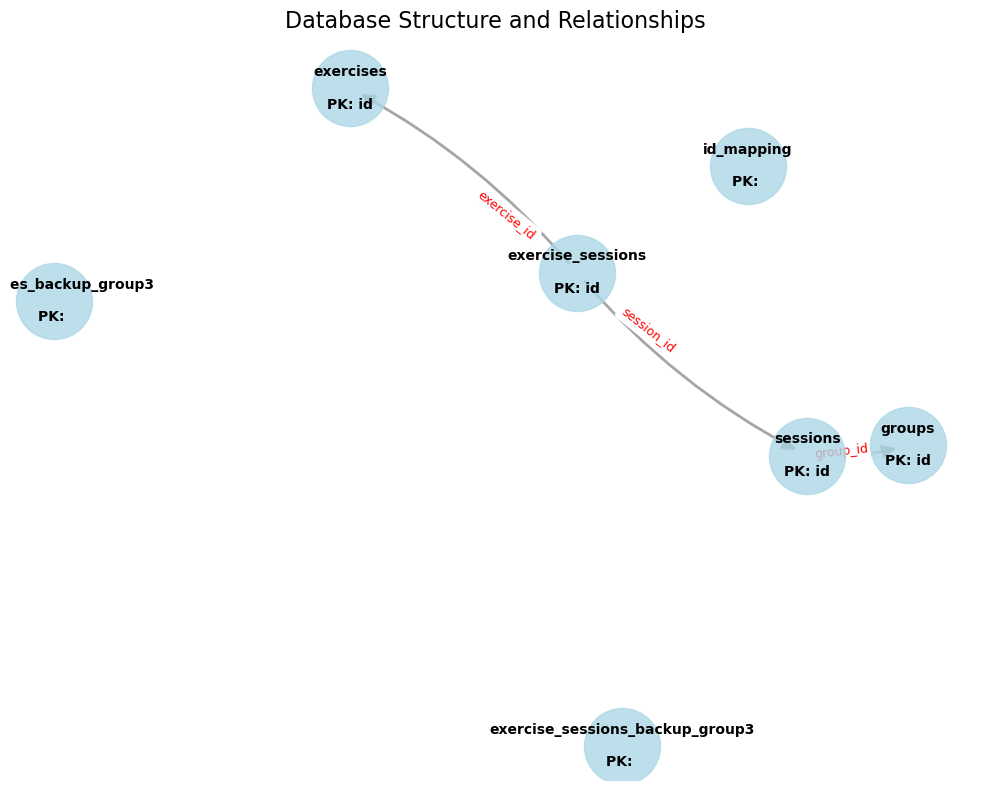

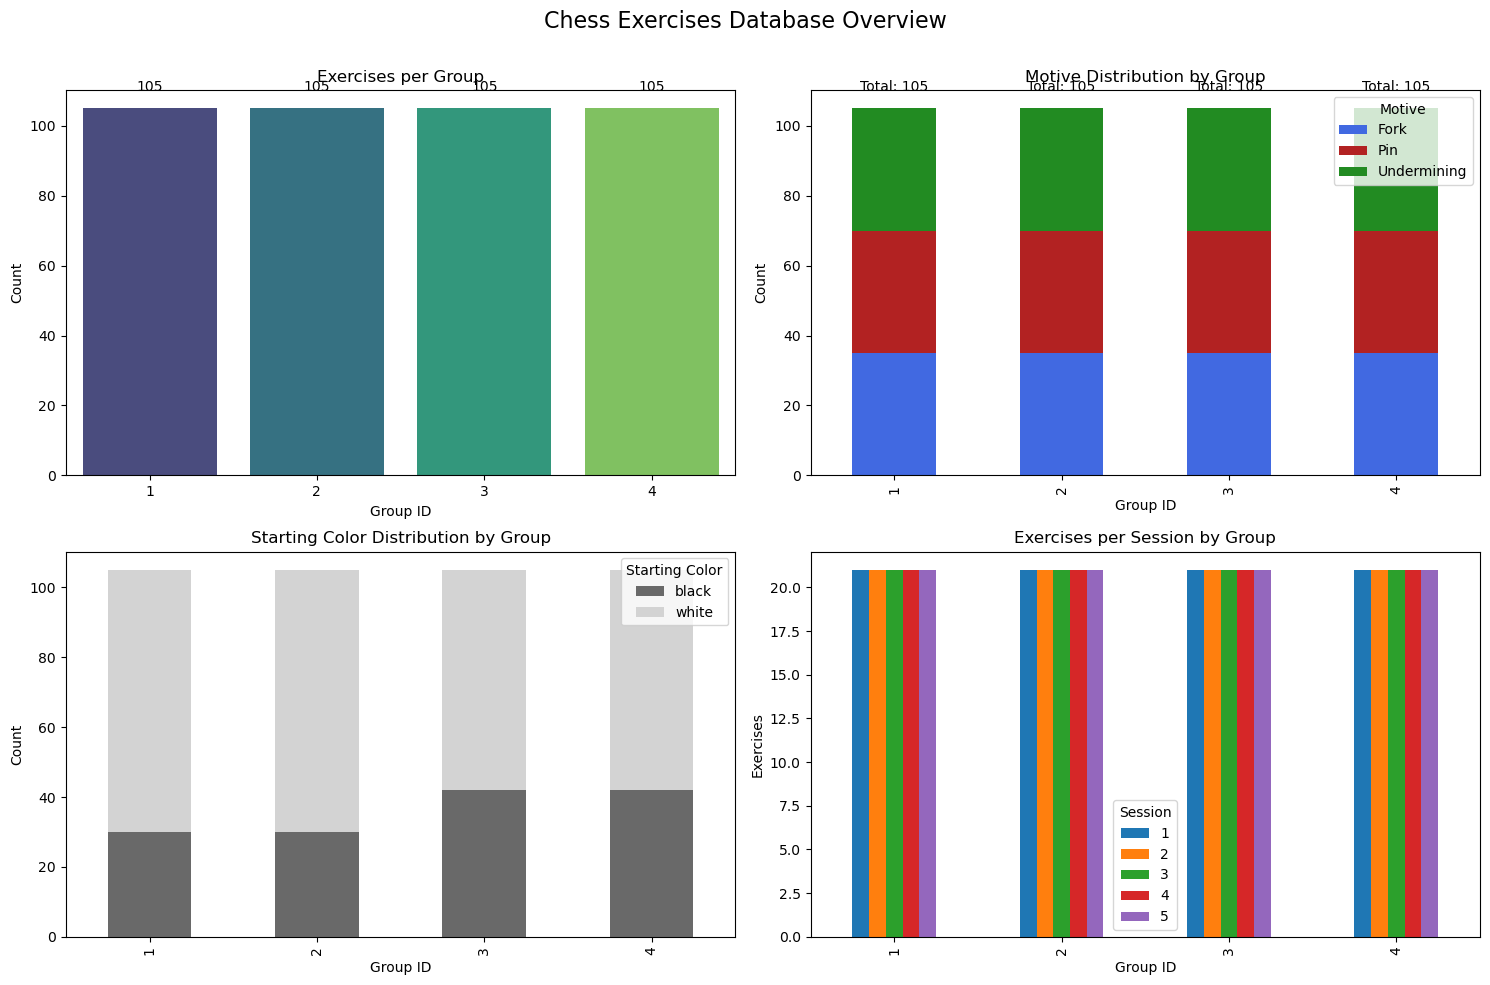

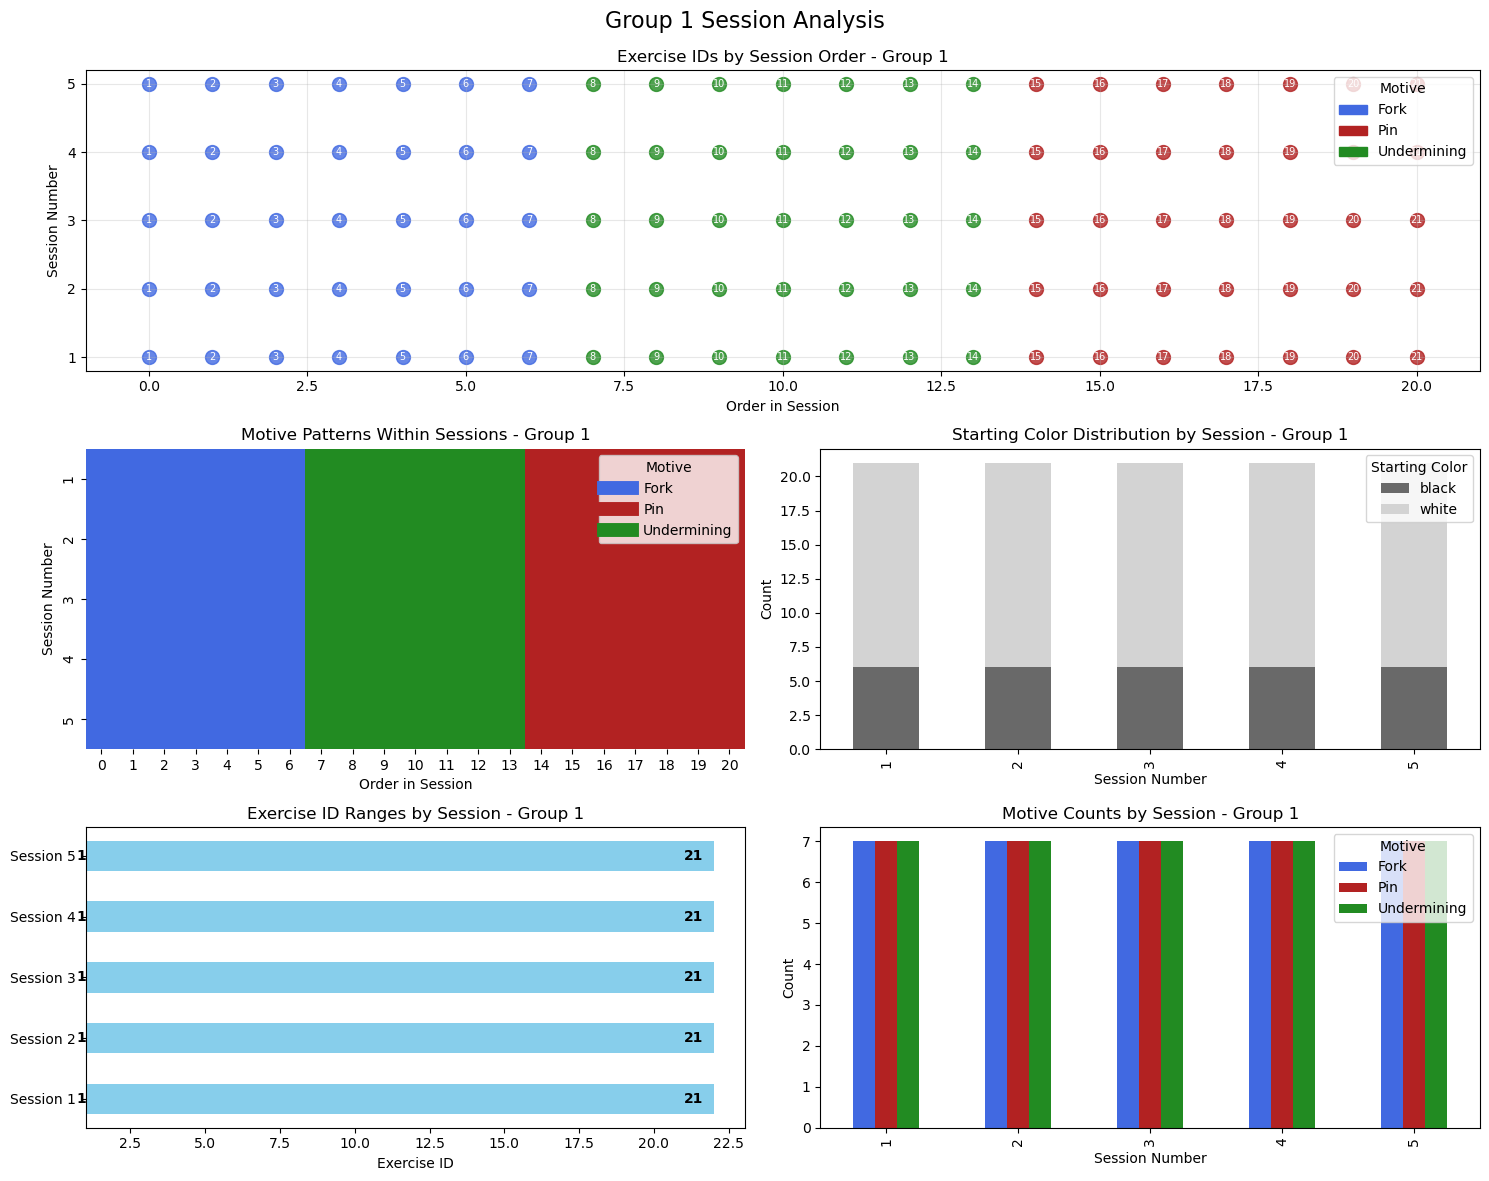

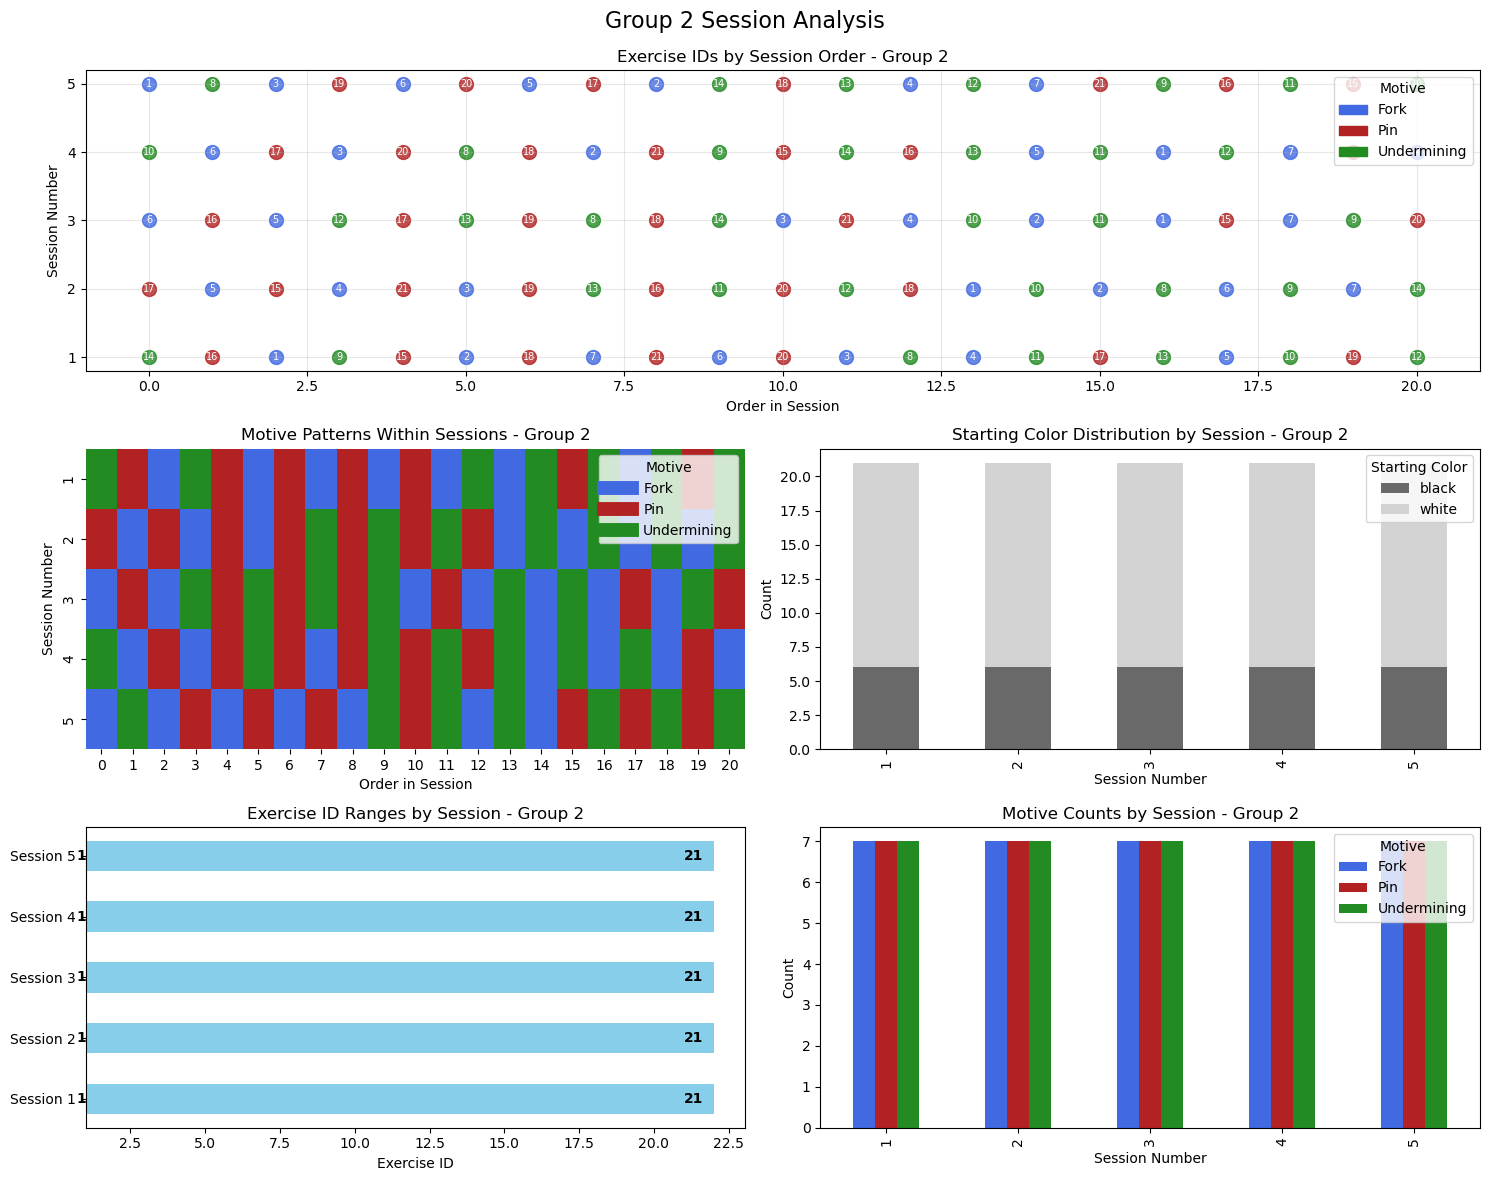

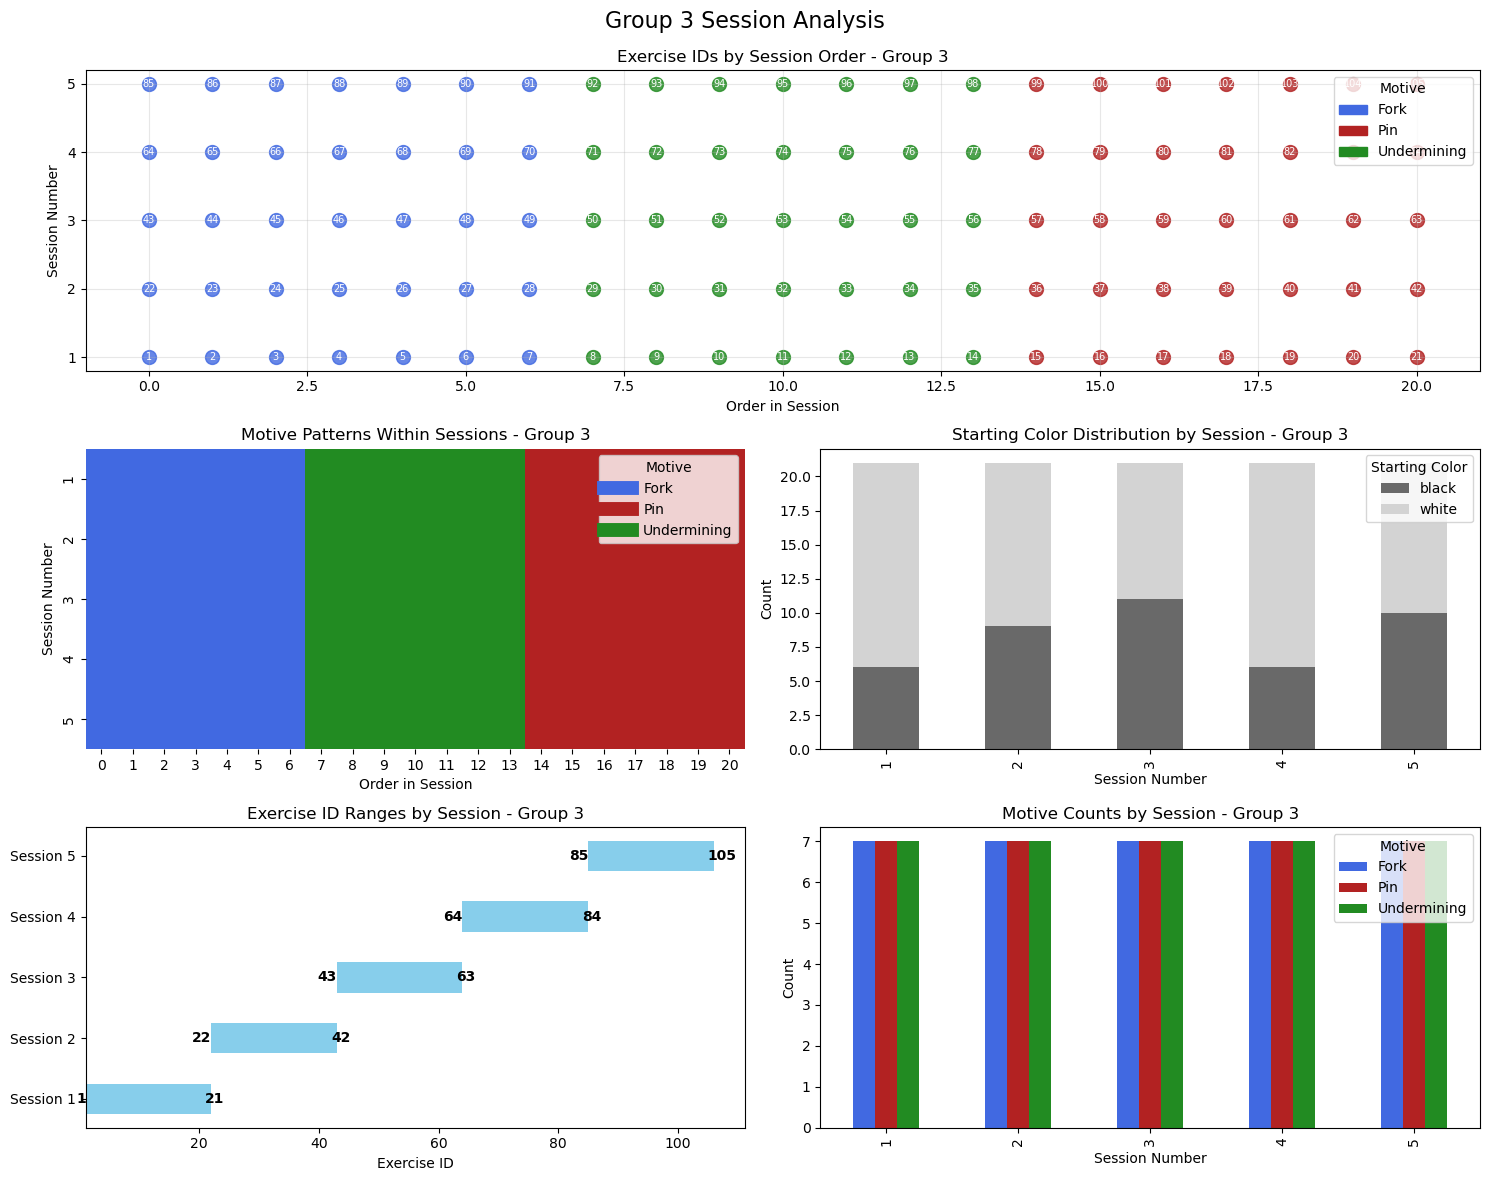

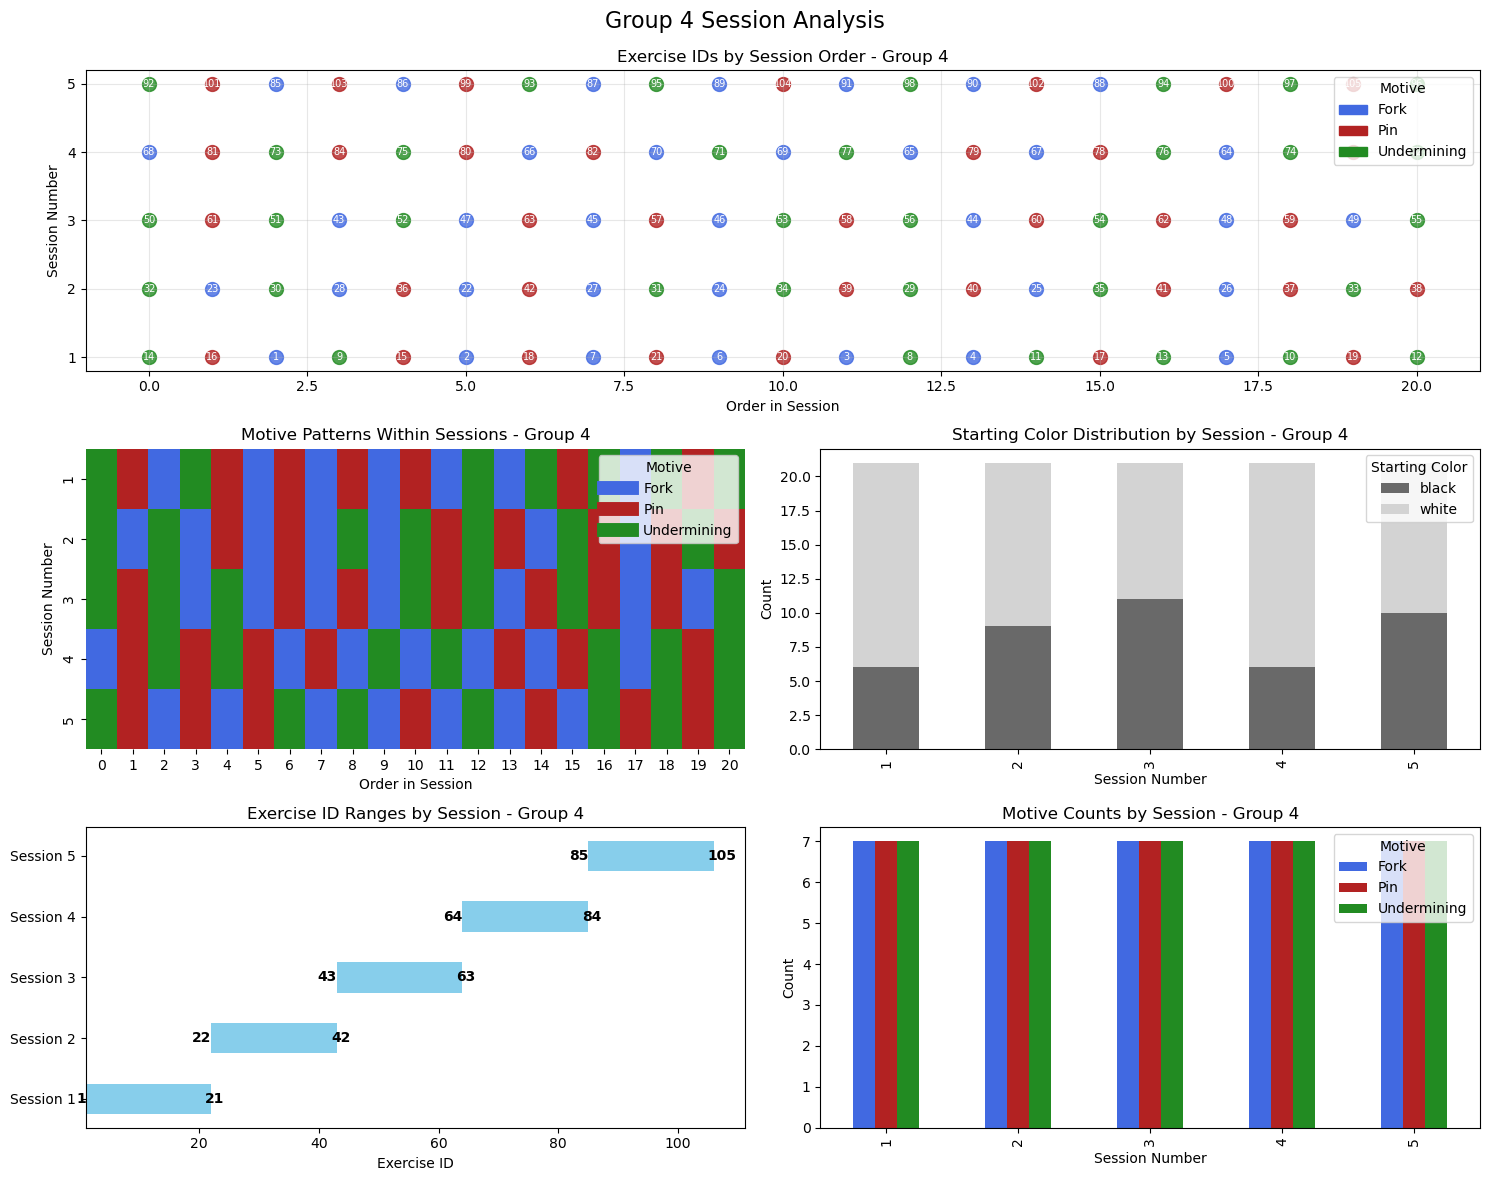

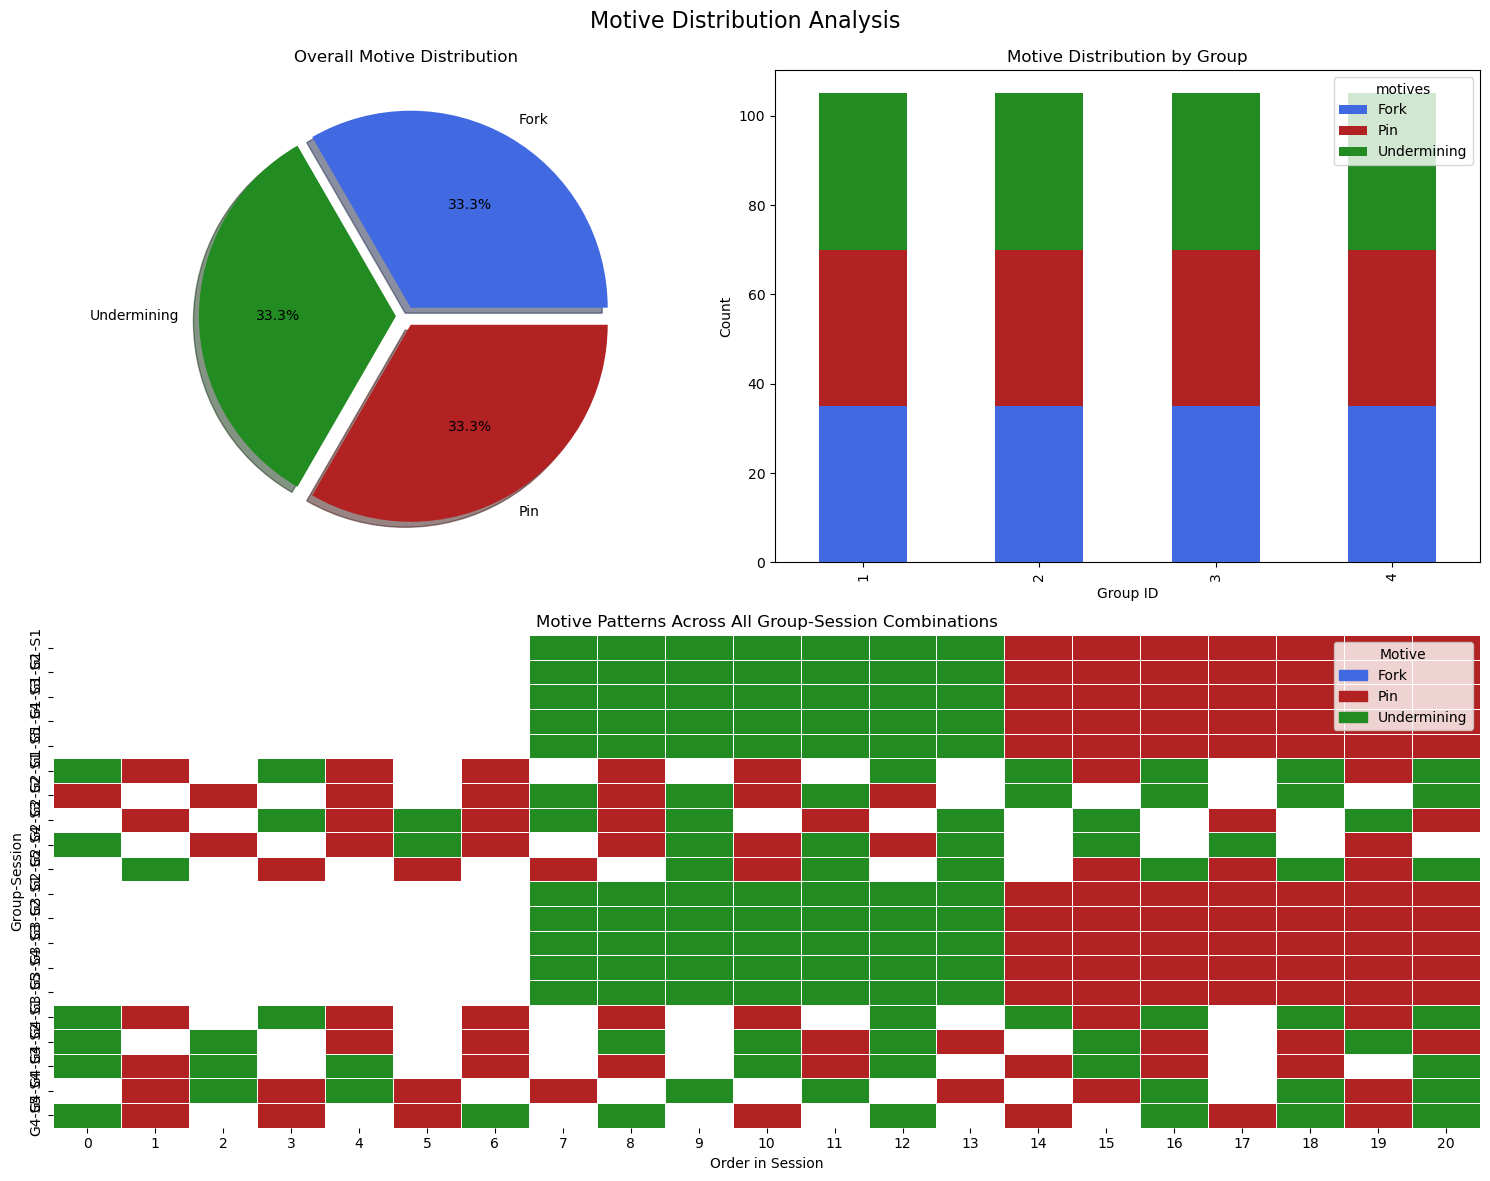

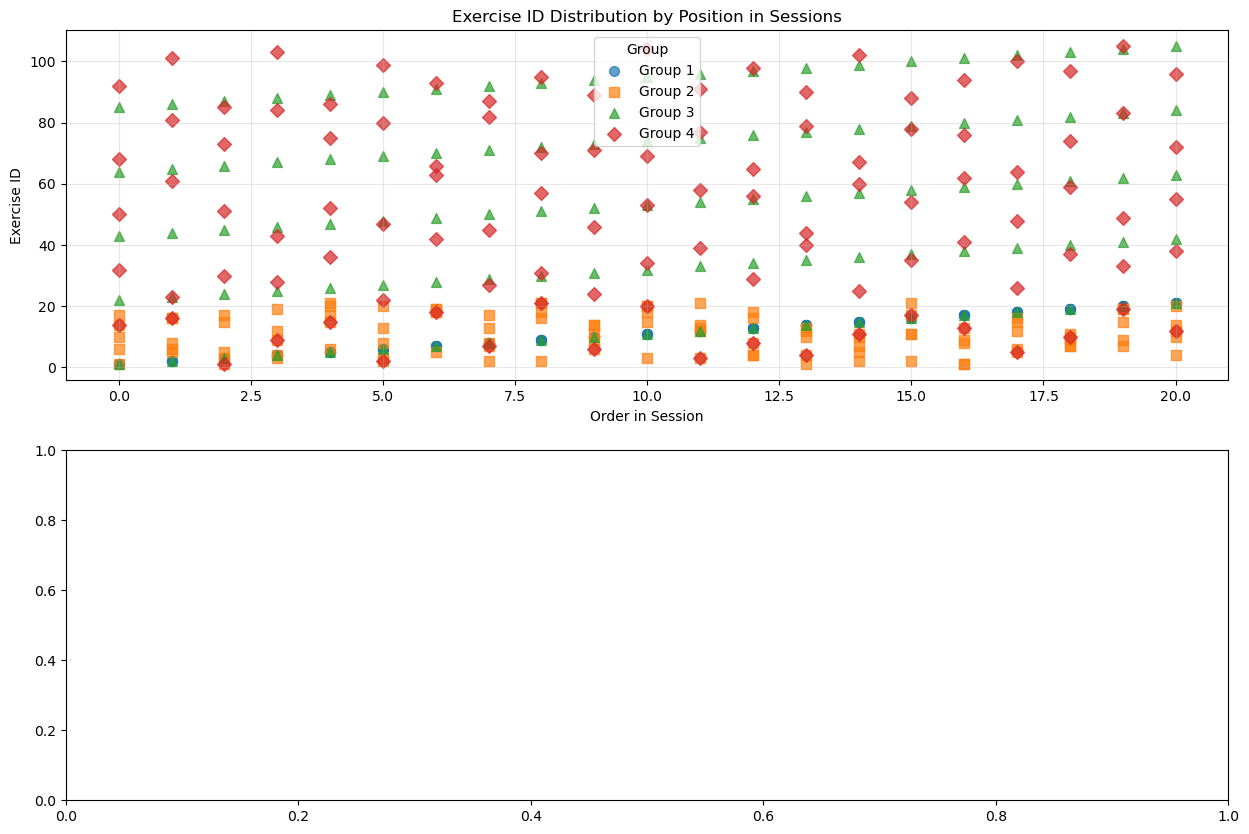

In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
from matplotlib.gridspec import GridSpec

# Connect to the database
conn = sqlite3.connect('chess_exercises.db')
cursor = conn.cursor()

try:
    print("Creating comprehensive visualizations for the chess exercises database...")

    # 1. First, get all exercise data with their relationships
    cursor.execute("""
    SELECT
        e.id as exercise_id,
        g.id as group_id,
        s.session_number,
        es.order_in_session,
        e.motives,
        e.starting_color
    FROM exercises e
    JOIN exercise_sessions es ON e.id = es.exercise_id
    JOIN sessions s ON es.session_id = s.id
    JOIN groups g ON s.group_id = g.id
    ORDER BY g.id, s.session_number, es.order_in_session
    """)

    all_data = cursor.fetchall()
    columns = ['exercise_id', 'group_id', 'session_number', 'order_in_session', 'motives', 'starting_color']
    df = pd.DataFrame(all_data, columns=columns)

    # Get unique values for color mapping
    all_motives = sorted(df['motives'].unique())
    all_starting_colors = sorted(df['starting_color'].unique())

    # Create color maps
    motive_colors = {
        'Fork': 'royalblue',
        'Pin': 'firebrick',
        'Undermining': 'forestgreen'
    }

    start_color_cmap = {'white': 'lightgray', 'black': 'dimgray'}

    # Save plot directory
    plots_dir = './'

    print(f"\nFound {len(df)} exercise-session mappings")
    print(f"Groups: {sorted(df['group_id'].unique())}")
    print(f"Sessions per group: {df.groupby('group_id')['session_number'].nunique().to_dict()}")
    print(f"Motives: {all_motives}")
    print(f"Starting colors: {all_starting_colors}")

    # ============== VISUALIZATION 1: DATABASE STRUCTURE DIAGRAM =================
    print("\nCreating database structure diagram...")

    # Get database schema
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = [row[0] for row in cursor.fetchall()]

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes for tables
    for table in tables:
        if table.startswith('sqlite_') or table.endswith('_backup'):
            continue
        G.add_node(table)

        # Get columns for this table
        cursor.execute(f"PRAGMA table_info({table})")
        columns = cursor.fetchall()

        # Add column info to node
        G.nodes[table]['columns'] = [col[1] for col in columns]
        G.nodes[table]['primary_key'] = [col[1] for col in columns if col[5] == 1]  # col[5] is the pk flag

    # Add edges based on foreign keys
    edges = [
        ('sessions', 'groups', 'group_id'),
        ('exercise_sessions', 'sessions', 'session_id'),
        ('exercise_sessions', 'exercises', 'exercise_id')
    ]

    for source, target, key in edges:
        G.add_edge(source, target, key=key)

    # Create the plot
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray',
                          connectionstyle='arc3,rad=0.1', arrowsize=20)

    # Add labels with column info
    labels = {}
    for node in G.nodes():
        labels[node] = f"{node}\n\nPK: {', '.join(G.nodes[node]['primary_key'])}"

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')

    # Add edge labels
    edge_labels = {(u, v): d['key'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9,
                                font_color='red', label_pos=0.3)

    plt.title("Database Structure and Relationships", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{plots_dir}database_structure.png", dpi=300, bbox_inches='tight')

    # ============== VISUALIZATION 2: GROUP OVERVIEW =================
    print("Creating group overview visualization...")

    plt.figure(figsize=(15, 10))

    # Create a GridSpec for complex layout
    gs = GridSpec(2, 2, figure=plt.gcf())

    # 1. Exercise count by group
    ax1 = plt.subplot(gs[0, 0])
    group_counts = df.groupby('group_id').size()
    sns.barplot(x=group_counts.index, y=group_counts.values, palette='viridis', ax=ax1)
    ax1.set_title('Exercises per Group')
    ax1.set_xlabel('Group ID')
    ax1.set_ylabel('Count')

    # Add count labels on bars
    for i, count in enumerate(group_counts):
        ax1.text(i, count + 5, str(count), ha='center')

    # 2. Motive distribution by group
    ax2 = plt.subplot(gs[0, 1])
    motive_counts = df.groupby(['group_id', 'motives']).size().unstack()
    motive_counts.plot(kind='bar', stacked=True, ax=ax2,
                      color=[motive_colors[m] for m in motive_counts.columns])
    ax2.set_title('Motive Distribution by Group')
    ax2.set_xlabel('Group ID')
    ax2.set_ylabel('Count')
    ax2.legend(title='Motive')

    # Add total count labels
    for i, total in enumerate(motive_counts.sum(axis=1)):
        ax2.text(i, total + 5, f"Total: {total}", ha='center')

    # 3. Starting color distribution by group
    ax3 = plt.subplot(gs[1, 0])
    color_counts = df.groupby(['group_id', 'starting_color']).size().unstack()
    color_counts.plot(kind='bar', stacked=True, ax=ax3,
                     color=[start_color_cmap[c] for c in color_counts.columns])
    ax3.set_title('Starting Color Distribution by Group')
    ax3.set_xlabel('Group ID')
    ax3.set_ylabel('Count')
    ax3.legend(title='Starting Color')

    # 4. Session count by group
    ax4 = plt.subplot(gs[1, 1])
    sessions_per_group = df.groupby(['group_id', 'session_number']).size().unstack()
    sessions_per_group.plot(kind='bar', ax=ax4)
    ax4.set_title('Exercises per Session by Group')
    ax4.set_xlabel('Group ID')
    ax4.set_ylabel('Exercises')
    ax4.legend(title='Session')

    plt.suptitle('Chess Exercises Database Overview', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"{plots_dir}group_overview.png", dpi=300, bbox_inches='tight')

    # ============== VISUALIZATION 3: SESSION ANALYSIS FOR EACH GROUP =================
    print("Creating session analysis visualizations...")

    for group_id in sorted(df['group_id'].unique()):
        group_df = df[df['group_id'] == group_id].copy()

        plt.figure(figsize=(15, 12))
        gs = GridSpec(3, 2, figure=plt.gcf())

        # 1. Exercise ID distribution across sessions
        ax1 = plt.subplot(gs[0, :])

        # Create a scatter plot of exercise IDs by session
        for session_num in sorted(group_df['session_number'].unique()):
            session_df = group_df[group_df['session_number'] == session_num]
            session_df = session_df.sort_values('order_in_session')

            # Plot each exercise colored by motive
            for _, row in session_df.iterrows():
                ax1.scatter(row['order_in_session'], session_num,
                           color=motive_colors[row['motives']],
                           s=100, alpha=0.8)
                ax1.text(row['order_in_session'], session_num, str(row['exercise_id']),
                        ha='center', va='center', fontsize=7, color='white')

        ax1.set_title(f'Exercise IDs by Session Order - Group {group_id}')
        ax1.set_xlabel('Order in Session')
        ax1.set_ylabel('Session Number')
        ax1.set_yticks(sorted(group_df['session_number'].unique()))
        ax1.grid(alpha=0.3)

        # Create legend for motives
        motive_patches = [Patch(color=motive_colors[m], label=m) for m in sorted(motive_colors.keys())]
        ax1.legend(handles=motive_patches, title='Motive', loc='upper right')

        # 2. Motive patterns within sessions
        ax2 = plt.subplot(gs[1, 0])

        # Create a heatmap showing motive patterns
        # First create a pivot table
        pivot_data = group_df.pivot_table(
            index='session_number',
            columns='order_in_session',
            values='motives',
            aggfunc='first'
        )

        # Map motives to numbers for coloring
        motive_to_num = {motive: i for i, motive in enumerate(sorted(motive_colors.keys()))}
        numeric_pivot = pivot_data.applymap(lambda x: motive_to_num.get(x, -1))

        # Create a custom colormap from the motive colors
        cmap = LinearSegmentedColormap.from_list(
            'motive_cmap',
            [motive_colors[m] for m in sorted(motive_colors.keys())],
            N=len(motive_colors)
        )

        sns.heatmap(numeric_pivot, cmap=cmap, cbar=False, ax=ax2)
        ax2.set_title(f'Motive Patterns Within Sessions - Group {group_id}')
        ax2.set_xlabel('Order in Session')
        ax2.set_ylabel('Session Number')

        # Add legend
        for i, motive in enumerate(sorted(motive_colors.keys())):
            ax2.plot([], [], color=motive_colors[motive], label=motive, linewidth=10)
        ax2.legend(title='Motive', loc='upper right')

        # 3. Starting color distribution by session
        ax3 = plt.subplot(gs[1, 1])

        color_counts_by_session = group_df.groupby(['session_number', 'starting_color']).size().unstack().fillna(0)
        color_counts_by_session.plot(kind='bar', stacked=True, ax=ax3,
                                    color=[start_color_cmap[c] for c in color_counts_by_session.columns])
        ax3.set_title(f'Starting Color Distribution by Session - Group {group_id}')
        ax3.set_xlabel('Session Number')
        ax3.set_ylabel('Count')
        ax3.legend(title='Starting Color')

        # 4. Exercise ID ranges by session
        ax4 = plt.subplot(gs[2, 0])

        session_id_ranges = group_df.groupby('session_number')['exercise_id'].agg(['min', 'max'])
        session_id_ranges['range'] = session_id_ranges['max'] - session_id_ranges['min'] + 1

        # Plot min-max ranges as horizontal bars
        for i, (session, row) in enumerate(session_id_ranges.iterrows()):
            ax4.barh(i, row['range'], left=row['min'], height=0.5, color='skyblue')
            ax4.text(row['min'], i, str(int(row['min'])), ha='right', va='center', fontweight='bold')
            ax4.text(row['max'], i, str(int(row['max'])), ha='left', va='center', fontweight='bold')

        ax4.set_yticks(range(len(session_id_ranges)))
        ax4.set_yticklabels([f"Session {s}" for s in session_id_ranges.index])
        ax4.set_title(f'Exercise ID Ranges by Session - Group {group_id}')
        ax4.set_xlabel('Exercise ID')

        # 5. Motive count by session
        ax5 = plt.subplot(gs[2, 1])

        motive_counts_by_session = group_df.groupby(['session_number', 'motives']).size().unstack()
        motive_counts_by_session.plot(kind='bar', ax=ax5,
                                     color=[motive_colors[m] for m in motive_counts_by_session.columns])
        ax5.set_title(f'Motive Counts by Session - Group {group_id}')
        ax5.set_xlabel('Session Number')
        ax5.set_ylabel('Count')
        ax5.legend(title='Motive')

        plt.suptitle(f'Group {group_id} Session Analysis', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.savefig(f"{plots_dir}group{group_id}_session_analysis.png", dpi=300, bbox_inches='tight')

    # ============== VISUALIZATION 4: MOTIVE DISTRIBUTION ANALYSIS =================
    print("Creating motive distribution analysis...")

    plt.figure(figsize=(15, 12))

    # 1. Overall motive distribution
    ax1 = plt.subplot(2, 2, 1)
    motive_counts_overall = df['motives'].value_counts()
    ax1.pie(motive_counts_overall, labels=motive_counts_overall.index, autopct='%1.1f%%',
           colors=[motive_colors[m] for m in motive_counts_overall.index],
           explode=[0.05]*len(motive_counts_overall), shadow=True)
    ax1.set_title('Overall Motive Distribution')

    # 2. Motive distribution by group
    ax2 = plt.subplot(2, 2, 2)
    motive_by_group = df.groupby(['group_id', 'motives']).size().unstack()
    motive_by_group.plot(kind='bar', stacked=True, ax=ax2,
                        color=[motive_colors[m] for m in motive_by_group.columns])
    ax2.set_title('Motive Distribution by Group')
    ax2.set_xlabel('Group ID')
    ax2.set_ylabel('Count')

    # 3. Motive patterns across all sessions
    ax3 = plt.subplot(2, 1, 2)

    # Create a matrix of group-session combinations
    groups = sorted(df['group_id'].unique())
    sessions = sorted(df['session_number'].unique())

    # Prepare for heatmap - we need a 2D grid of group-session combinations
    heatmap_data = np.zeros((len(groups) * len(sessions), max(df['order_in_session']) + 1))
    row_labels = []

    for i, group_id in enumerate(groups):
        for j, session_num in enumerate(sessions):
            subset = df[(df['group_id'] == group_id) & (df['session_number'] == session_num)]

            if not subset.empty:
                row_idx = i * len(sessions) + j
                row_labels.append(f"G{group_id}-S{session_num}")

                for _, row in subset.iterrows():
                    col_idx = row['order_in_session']
                    motive_val = list(motive_colors.keys()).index(row['motives'])
                    heatmap_data[row_idx, col_idx] = motive_val + 1  # +1 so 0 is reserved for empty cells

    # Create a mask for empty cells
    mask = heatmap_data == 0

    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list(
        'motive_cmap',
        ['white'] + [motive_colors[m] for m in sorted(motive_colors.keys())],
        N=len(motive_colors) + 1
    )

    # Create heatmap
    sns.heatmap(heatmap_data, cmap=cmap, mask=mask, cbar=False,
               linewidths=0.5, linecolor='white', ax=ax3)

    ax3.set_title('Motive Patterns Across All Group-Session Combinations')
    ax3.set_xlabel('Order in Session')
    ax3.set_ylabel('Group-Session')
    ax3.set_yticks(np.arange(len(row_labels)) + 0.5)
    ax3.set_yticklabels(row_labels)

    # Add legend
    patches = [Patch(color=motive_colors[m], label=m) for m in sorted(motive_colors.keys())]
    ax3.legend(handles=patches, title='Motive', loc='upper right')

    plt.suptitle('Motive Distribution Analysis', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig(f"{plots_dir}motive_distribution_analysis.png", dpi=300, bbox_inches='tight')

    # ============== VISUALIZATION 5: EXERCISE SEQUENCE ANALYSIS =================
    print("Creating exercise sequence analysis...")

    plt.figure(figsize=(15, 10))

    # 1. Exercise ID Sequence Analysis
    # Examine how IDs are distributed across the database
    plt.subplot(2, 1, 1)

    # Plot exercise IDs by their position in each group-session
    group_markers = ['o', 's', '^', 'D']  # Different marker for each group

    for i, group_id in enumerate(sorted(df['group_id'].unique())):
        group_df = df[df['group_id'] == group_id]

        for session_num in sorted(group_df['session_number'].unique()):
            session_df = group_df[group_df['session_number'] == session_num]

            # Use a unique label only for the first point of each group
            label = f"Group {group_id}" if session_num == 1 else None

            plt.scatter(session_df['order_in_session'], session_df['exercise_id'],
                       color=f'C{group_id-1}', marker=group_markers[i % len(group_markers)],
                       alpha=0.7, s=50, label=label)

    plt.title('Exercise ID Distribution by Position in Sessions')
    plt.xlabel('Order in Session')
    plt.ylabel('Exercise ID')
    plt.grid(alpha=0.3)
    plt.legend(title='Group')

    # 2. Motive transition analysis
    plt.subplot(2, 1, 2)

    # Calculate transitions between motives within each session
    transitions = []

    for group_id in sorted(df['group_id'].unique()):
        group_df = df[df['group_id'] == group_id]

        for session_num in sorted(group_df['session_number'].unique()):
            session_df = group_df[group_df['session_number'] == session_num].sort_values('order_in_session')

            if len(session_df) > 1:
                motives = session_df['motives'].tolist()

                for i in range(len(motives) - 1):
                    transitions.append((motives[i], motives[i+1]))

    # Count transitions
    transition_counts = pd.Series(transitions).value_counts().unstack(fill_value=0)

    # Create a transition matrix
    motive_list = sorted(motive_colors.keys())
    transition_matrix = np.zeros((len(motive_list), len(motive_list)))

    for i, from_motive in enumerate(motive_list):
        for j, to_motive in enumerate(motive_list):
            if from_motive in transition_counts and to_motive in transition_counts[from_motive]:
                transition_matrix[i, j] = transition_counts[from_motive][to_motive]

    # Create a heatmap
    sns.heatmap(transition_matrix, annot=True, fmt='g', cmap='Blues',
               xticklabels=motive_list, yticklabels=motive_list)

    plt.title('Motive Transition Counts')
    plt.xlabel('To Motive')
    plt.ylabel('From Motive')

    plt.tight_layout()
    plt.savefig(f"{plots_dir}exercise_sequence_analysis.png", dpi=300, bbox_inches='tight')

    # ============== VISUALIZATION 6: 3D VISUALIZATION =================
    print("Creating 3D visualization...")

    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D scatter plot of exercises
    for group_id in sorted(df['group_id'].unique()):
        group_df = df[df['group_id'] == group_id]

        # Use different markers for different motives
        for motive in motive_colors:
            motive_df = group_df[group_df['motives'] == motive]

            ax.scatter(
                motive_df['group_id'],
                motive_df['session_number'],
                motive_df['exercise_id'],
                c=motive_colors[motive],
                marker='o',
                s=50,
                alpha=0.7,
                label=f"{motive}" if group_id == 1 else None  # Only label once
            )

    # Add labels and title
    ax.set_xlabel('Group ID')
    ax.set_ylabel('Session Number')
    ax.set_zlabel('Exercise ID')
    ax.set_title('3D Visualization of Exercises by Group, Session, and ID')

    # Set integer ticks for x and y axes
    ax.set_xticks(sorted(df['group_id'].unique()))
    ax.set_yticks(sorted(df['session_number'].unique()))

    # Add legend
    ax.legend(title='Motive')

    plt.tight_layout()
    plt.savefig(f"{plots_dir}3d_visualization.png", dpi=300, bbox_inches='tight')

    print("\nAll visualizations have been created and saved!")

except Exception as e:
    print(f"Error during visualization creation: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Close the connection
    conn.close()